In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 행 많이보기
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정

fm.get_fontconfig_fonts()
# fname 옵션을 사용하는 방법

font_location = 'C:\\WINDOWS\\Fonts\\\x7f\x7f\x7f\x7f.TTF' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

# 지수 표현 안보기

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [2]:
# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])
viewrate=pd.read_excel('./Data/시청률 데이터.xlsx',encoding='UTF-8',header=1)

# 전처리

In [3]:
# 무형 제거
data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000



# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )




# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3
data['yy-mm-dd']=data['time'].apply(lambda time:str(time).split(' ')[0])
data['s-hh-mm']=data['time'].apply(lambda time:str(time).split(' ')[1])
data['s-hh-mm']=data['s-hh-mm'].apply(lambda x: x.split(':')[0]+":"+x.split(':')[1])
data['f-hh-mm']=data['s-hh-mm']

data['year']=data['time'].apply(lambda time:time.year)
data['month']=data['time'].apply(lambda time:time.month)
data['date']=data['time'].apply(lambda time: time.day)

data['hour']=data['time'].apply(lambda time:time.hour)
data['minute']=data['time'].apply(lambda time:time.minute)

data['dayofweek']=data['time'].apply(lambda time:time.dayofweek) # Monday=0, Sunday=6.

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


In [4]:
# 시청률이 해당 일 02:00~01:59(익일)으로 나와있음.
# 00:00~01:59의 시청율이 전날의 00:00~01:59 시청율 이므로
# 하나씩 아래로 밀어서 그 날의 00:00~01:59의 시청율을 구하고, 
# 2019-01-01 00:00~01:59의 경우, 2019-12-31의 시청율로 퉁 침.

viewrate.set_index(viewrate['시간대'], inplace=True)
viewrate.drop(['시간대'],axis=1,inplace=True)
viewrate = viewrate.transpose()

In [5]:
#print('row(행):',len(viewrate),'\ncolumn(열):',len(viewrate.iloc[0,:]))

nextday시청률=viewrate.loc[:,'00:00':]
nextdaycolumn=nextday시청률.columns
nextdayindex=nextday시청률.index
a=nextday시청률.loc['2019-12-31',:]
a=a.reset_index()
a.drop('시간대',axis=1,inplace=True)
a=a.transpose()
a.columns=nextdaycolumn


nextday시청률=nextday시청률.drop('2019-12-31',axis=0)
nextday시청률=nextday시청률.reset_index()
nextday시청률.drop(['index'],axis=1,inplace=True)


nextday시청률=pd.concat([a,nextday시청률],axis=0)
nextday시청률=nextday시청률.reset_index()
nextday시청률.drop('index',axis=1,inplace=True)
nextday시청률=nextday시청률.set_index(nextdayindex)

In [6]:
# 드롭을 하지 말고, 00:00~01:59 데이터의 경우 column명에 +24를 해서 보존하자
plus24=viewrate.loc[:,'00:00':].columns

notplus24=viewrate.loc[:,:'23:59'].columns #inex type
notplus24=list(notplus24) # list형태로 변환


plus24result=[]
for i in range(len(plus24)-1):
   
    hour=int(plus24[i].split(':')[0])+24
    minute=int(plus24[i].split(':')[1])
    string='{0:02d}'.format(hour)+':'+'{0:02d}'.format(minute)
    plus24result.append(string)
plus24result.append(plus24[-1])
newcolumn=notplus24+plus24result

In [7]:
viewrate.columns=newcolumn

In [8]:
viewrate=pd.concat([nextday시청률,viewrate],axis=1)
시청률unstack=viewrate.transpose().unstack()
#시청률unstack['2019-01-02']['01:59']
시청률unstack

2019-01-01                00:00                 0.024
                          00:01                 0.024
                          00:02                 0.024
                          00:03                 0.024
                          00:04                 0.024
                                                ...  
2019-01-01 to 2019-12-31  25:56                 0.004
                          25:57                 0.004
                          25:58                 0.004
                          25:59                 0.004
                          월화수목금토일02:00-01:59    0.004
Length: 571692, dtype: float64

In [9]:
# 끝난 시각 만들기
finishtime=[]
for i in range(len(data)):
    wdate=data.iloc[i,9]#년-월-일
    wstime=data.iloc[i,10]#s-hh-mm
    wduring=data.iloc[i,2]#exposure_time
    
    plushour,finishmin=divmod(int(wstime.split(':')[1])+int(wduring),60)#분끼리 더해서 60을 넘으면, 시간으로 반올림
    finishhour=int(wstime.split(':')[0])+int(plushour)
    #a,finishhour=divmod(finishhour,24)#24==0 바꾸는 작업
    
    finishtime.append('{0:02d}'.format(finishhour)+':'+'{0:02d}'.format(finishmin)) #2.6이상

data['f-hh-mm']=finishtime

#시청률unstack['2019-01-01']['02:00':'02:20'].sum()


In [10]:
시청률_sumlist=[]
for i in range(len(data)):
    wdate=data.iloc[i,9]#년-월-일
    wstime=data.iloc[i,10]#시작시각
    wftime=data.iloc[i,11]#끝시각
    print(wdate,wstime,wftime)
    if wdate=='2020-01-01':
        wdate='2019-12-31'
        wstime='24:00'
        wftime='24:20'
    else:
        None
    시청률_sumlist.append(시청률unstack[wdate][wstime:wftime].sum())

data['tvrate']=시청률_sumlist

2019-01-01 06:00 06:20
2019-01-01 06:00 06:20
2019-01-01 06:20 06:40
2019-01-01 06:20 06:40
2019-01-01 06:40 07:00
2019-01-01 06:40 07:00
2019-01-01 07:00 07:20
2019-01-01 07:20 07:40
2019-01-01 07:40 08:00
2019-01-01 08:00 08:20
2019-01-01 08:20 08:40
2019-01-01 08:40 09:00
2019-01-01 09:00 09:20
2019-01-01 09:20 09:40
2019-01-01 09:40 10:00
2019-01-01 10:00 10:20
2019-01-01 10:20 10:40
2019-01-01 10:40 11:00
2019-01-01 11:00 11:20
2019-01-01 11:20 11:40
2019-01-01 12:00 12:20
2019-01-01 12:20 12:40
2019-01-01 12:40 13:00
2019-01-01 13:00 13:30
2019-01-01 13:30 14:00
2019-01-01 14:00 14:30
2019-01-01 14:00 14:30
2019-01-01 14:30 15:00
2019-01-01 14:30 15:00
2019-01-01 15:00 15:20
2019-01-01 15:20 15:40
2019-01-01 15:40 16:00
2019-01-01 16:00 16:20
2019-01-01 16:20 16:40
2019-01-01 16:40 17:00
2019-01-01 17:00 17:20
2019-01-01 17:20 17:40
2019-01-01 17:40 18:00
2019-01-01 18:00 18:20
2019-01-01 18:20 18:40
2019-01-01 18:40 19:00
2019-01-01 19:00 19:20
2019-01-01 19:20 19:40
2019-01-01 

2019-01-05 20:40 21:00
2019-01-05 21:00 21:20
2019-01-05 21:00 21:20
2019-01-05 21:00 21:20
2019-01-05 21:00 21:20
2019-01-05 21:00 21:20
2019-01-05 21:00 21:20
2019-01-05 21:20 21:40
2019-01-05 21:20 21:40
2019-01-05 21:20 21:40
2019-01-05 21:20 21:40
2019-01-05 21:20 21:40
2019-01-05 21:20 21:40
2019-01-05 21:40 22:00
2019-01-05 21:40 22:00
2019-01-05 21:40 22:00
2019-01-05 21:40 22:00
2019-01-05 21:40 22:00
2019-01-05 21:40 22:00
2019-01-05 22:00 22:20
2019-01-05 22:20 22:40
2019-01-05 22:40 23:00
2019-01-05 23:00 23:20
2019-01-05 23:00 23:20
2019-01-05 23:20 23:40
2019-01-05 23:20 23:40
2019-01-05 23:40 24:00
2019-01-05 23:40 24:00
2019-01-06 00:00 00:20
2019-01-06 00:20 00:40
2019-01-06 00:40 01:00
2019-01-06 01:00 01:20
2019-01-06 01:20 01:40
2019-01-06 01:40 01:57
2019-01-06 06:00 06:20
2019-01-06 06:20 06:40
2019-01-06 06:40 07:00
2019-01-06 07:00 07:20
2019-01-06 07:20 07:40
2019-01-06 07:40 08:00
2019-01-06 08:00 08:20
2019-01-06 08:20 08:40
2019-01-06 08:40 09:00
2019-01-06 

2019-01-10 06:40 07:00
2019-01-10 06:40 07:00
2019-01-10 07:00 07:20
2019-01-10 07:20 07:40
2019-01-10 07:40 08:00
2019-01-10 08:00 08:20
2019-01-10 08:20 08:40
2019-01-10 08:40 09:00
2019-01-10 09:00 09:30
2019-01-10 09:30 10:00
2019-01-10 10:00 10:20
2019-01-10 10:00 10:20
2019-01-10 10:00 10:20
2019-01-10 10:00 10:20
2019-01-10 10:20 10:40
2019-01-10 10:20 10:40
2019-01-10 10:20 10:40
2019-01-10 10:20 10:40
2019-01-10 10:40 11:00
2019-01-10 10:40 11:00
2019-01-10 10:40 11:00
2019-01-10 10:40 11:00
2019-01-10 11:00 11:20
2019-01-10 11:20 11:40
2019-01-10 11:40 12:00
2019-01-10 12:00 12:20
2019-01-10 12:20 12:40
2019-01-10 12:40 13:00
2019-01-10 13:00 13:20
2019-01-10 13:20 13:40
2019-01-10 13:40 14:00
2019-01-10 14:00 14:20
2019-01-10 14:20 14:40
2019-01-10 14:40 15:00
2019-01-10 15:00 15:20
2019-01-10 15:20 15:40
2019-01-10 15:40 16:00
2019-01-10 16:00 16:20
2019-01-10 16:20 16:40
2019-01-10 16:40 17:00
2019-01-10 17:00 17:20
2019-01-10 17:20 17:40
2019-01-10 17:40 18:00
2019-01-10 

2019-01-14 09:20 09:40
2019-01-14 09:40 10:00
2019-01-14 09:40 10:00
2019-01-14 09:40 10:00
2019-01-14 09:40 10:00
2019-01-14 10:00 10:20
2019-01-14 10:20 10:40
2019-01-14 10:40 11:00
2019-01-14 11:00 11:30
2019-01-14 11:30 12:00
2019-01-14 12:00 12:20
2019-01-14 12:20 12:40
2019-01-14 12:40 13:00
2019-01-14 13:00 13:20
2019-01-14 13:20 13:40
2019-01-14 13:40 14:00
2019-01-14 14:00 14:20
2019-01-14 14:20 14:40
2019-01-14 14:40 15:00
2019-01-14 15:00 15:20
2019-01-14 15:20 15:40
2019-01-14 15:40 16:00
2019-01-14 16:00 16:20
2019-01-14 16:20 16:40
2019-01-14 16:40 17:00
2019-01-14 17:00 17:20
2019-01-14 17:20 17:40
2019-01-14 17:40 18:00
2019-01-14 18:00 18:20
2019-01-14 18:00 18:20
2019-01-14 18:00 18:20
2019-01-14 18:00 18:20
2019-01-14 18:20 18:40
2019-01-14 18:20 18:40
2019-01-14 18:20 18:40
2019-01-14 18:20 18:40
2019-01-14 18:40 19:00
2019-01-14 18:40 19:00
2019-01-14 18:40 19:00
2019-01-14 18:40 19:00
2019-01-14 19:00 19:20
2019-01-14 19:20 19:40
2019-01-14 19:40 20:00
2019-01-14 

2019-01-18 16:40 17:00
2019-01-18 17:00 17:20
2019-01-18 17:20 17:40
2019-01-18 17:40 18:00
2019-01-18 18:00 18:20
2019-01-18 18:00 18:20
2019-01-18 18:20 18:40
2019-01-18 18:20 18:40
2019-01-18 18:40 19:00
2019-01-18 18:40 19:00
2019-01-18 19:00 19:20
2019-01-18 19:20 19:40
2019-01-18 19:40 20:00
2019-01-18 20:00 20:20
2019-01-18 20:00 20:20
2019-01-18 20:20 20:40
2019-01-18 20:20 20:40
2019-01-18 20:40 21:00
2019-01-18 20:40 21:00
2019-01-18 21:00 21:20
2019-01-18 21:20 21:40
2019-01-18 21:40 22:00
2019-01-18 22:00 22:20
2019-01-18 22:00 22:20
2019-01-18 22:20 22:40
2019-01-18 22:20 22:40
2019-01-18 22:40 23:00
2019-01-18 22:40 23:00
2019-01-18 23:00 23:20
2019-01-18 23:00 23:20
2019-01-18 23:20 23:40
2019-01-18 23:20 23:40
2019-01-18 23:40 24:00
2019-01-18 23:40 24:00
2019-01-19 00:00 00:20
2019-01-19 00:20 00:40
2019-01-19 00:40 01:00
2019-01-19 01:00 01:20
2019-01-19 01:00 01:20
2019-01-19 01:20 01:40
2019-01-19 01:20 01:40
2019-01-19 01:40 01:56
2019-01-19 01:40 01:56
2019-01-19 

2019-01-22 11:40 12:00
2019-01-22 11:40 12:00
2019-01-22 11:40 12:00
2019-01-22 12:00 12:20
2019-01-22 12:20 12:40
2019-01-22 12:40 13:00
2019-01-22 13:00 13:20
2019-01-22 13:20 13:40
2019-01-22 13:40 14:00
2019-01-22 14:00 14:20
2019-01-22 14:20 14:40
2019-01-22 14:40 15:00
2019-01-22 15:00 15:20
2019-01-22 15:20 15:40
2019-01-22 15:40 16:00
2019-01-22 16:00 16:20
2019-01-22 16:20 16:40
2019-01-22 16:40 17:00
2019-01-22 17:00 17:20
2019-01-22 17:00 17:20
2019-01-22 17:20 17:40
2019-01-22 17:20 17:40
2019-01-22 17:40 18:00
2019-01-22 17:40 18:00
2019-01-22 18:00 18:20
2019-01-22 18:20 18:40
2019-01-22 18:40 19:00
2019-01-22 19:00 19:20
2019-01-22 19:00 19:20
2019-01-22 19:00 19:20
2019-01-22 19:20 19:40
2019-01-22 19:20 19:40
2019-01-22 19:20 19:40
2019-01-22 19:40 20:00
2019-01-22 19:40 20:00
2019-01-22 19:40 20:00
2019-01-22 20:00 20:20
2019-01-22 20:00 20:20
2019-01-22 20:00 20:20
2019-01-22 20:00 20:20
2019-01-22 20:00 20:20
2019-01-22 20:00 20:20
2019-01-22 20:20 20:40
2019-01-22 

2019-01-26 10:40 11:00
2019-01-26 11:00 11:30
2019-01-26 11:30 12:00
2019-01-26 12:00 12:20
2019-01-26 12:20 12:40
2019-01-26 12:40 13:00
2019-01-26 13:00 13:20
2019-01-26 13:20 13:40
2019-01-26 13:40 14:00
2019-01-26 14:00 14:20
2019-01-26 14:20 14:40
2019-01-26 14:40 15:00
2019-01-26 15:00 15:20
2019-01-26 15:20 15:40
2019-01-26 15:40 16:00
2019-01-26 16:00 16:20
2019-01-26 16:20 16:40
2019-01-26 16:40 17:00
2019-01-26 17:00 17:20
2019-01-26 17:20 17:40
2019-01-26 17:40 18:00
2019-01-26 18:20 18:40
2019-01-26 18:40 19:00
2019-01-26 19:00 19:20
2019-01-26 19:20 19:40
2019-01-26 19:40 20:00
2019-01-26 20:00 20:20
2019-01-26 20:20 20:40
2019-01-26 20:40 21:00
2019-01-26 21:00 21:20
2019-01-26 21:20 21:40
2019-01-26 21:40 22:00
2019-01-26 22:00 22:20
2019-01-26 22:00 22:20
2019-01-26 22:20 22:40
2019-01-26 22:20 22:40
2019-01-26 22:40 23:00
2019-01-26 22:40 23:00
2019-01-26 23:00 23:20
2019-01-26 23:20 23:40
2019-01-26 23:40 24:00
2019-01-27 00:00 00:20
2019-01-27 00:00 00:20
2019-01-27 

2019-01-30 19:40 20:00
2019-01-30 19:40 20:00
2019-01-30 19:40 20:00
2019-01-30 19:40 20:00
2019-01-30 20:00 20:20
2019-01-30 20:00 20:20
2019-01-30 20:20 20:40
2019-01-30 20:20 20:40
2019-01-30 20:40 21:00
2019-01-30 20:40 21:00
2019-01-30 21:00 21:20
2019-01-30 21:00 21:20
2019-01-30 21:20 21:40
2019-01-30 21:20 21:40
2019-01-30 21:40 22:00
2019-01-30 21:40 22:00
2019-01-30 22:00 22:20
2019-01-30 22:00 22:20
2019-01-30 22:00 22:20
2019-01-30 22:00 22:20
2019-01-30 22:00 22:20
2019-01-30 22:00 22:20
2019-01-30 22:20 22:40
2019-01-30 22:20 22:40
2019-01-30 22:20 22:40
2019-01-30 22:20 22:40
2019-01-30 22:20 22:40
2019-01-30 22:20 22:40
2019-01-30 22:40 23:00
2019-01-30 22:40 23:00
2019-01-30 22:40 23:00
2019-01-30 22:40 23:00
2019-01-30 22:40 23:00
2019-01-30 22:40 23:00
2019-01-30 23:00 23:20
2019-01-30 23:00 23:20
2019-01-30 23:00 23:20
2019-01-30 23:00 23:20
2019-01-30 23:20 23:40
2019-01-30 23:20 23:40
2019-01-30 23:20 23:40
2019-01-30 23:20 23:40
2019-01-30 23:40 24:00
2019-01-30 

2019-02-03 13:40 14:00
2019-02-03 13:40 14:00
2019-02-03 14:00 14:20
2019-02-03 14:00 14:20
2019-02-03 14:00 14:20
2019-02-03 14:00 14:20
2019-02-03 14:20 14:40
2019-02-03 14:20 14:40
2019-02-03 14:20 14:40
2019-02-03 14:20 14:40
2019-02-03 14:40 15:00
2019-02-03 14:40 15:00
2019-02-03 14:40 15:00
2019-02-03 14:40 15:00
2019-02-03 15:00 15:20
2019-02-03 15:20 15:40
2019-02-03 15:40 16:00
2019-02-03 16:00 16:20
2019-02-03 16:20 16:40
2019-02-03 16:40 17:00
2019-02-03 17:00 17:20
2019-02-03 17:00 17:20
2019-02-03 17:20 17:40
2019-02-03 17:20 17:40
2019-02-03 17:40 18:00
2019-02-03 17:40 18:00
2019-02-03 18:00 18:20
2019-02-03 18:20 18:40
2019-02-03 18:40 19:00
2019-02-03 19:00 19:20
2019-02-03 19:00 19:20
2019-02-03 19:20 19:40
2019-02-03 19:20 19:40
2019-02-03 19:40 20:00
2019-02-03 19:40 20:00
2019-02-03 20:00 20:20
2019-02-03 20:20 20:40
2019-02-03 20:40 21:00
2019-02-03 21:00 21:20
2019-02-03 21:00 21:20
2019-02-03 21:00 21:20
2019-02-03 21:00 21:20
2019-02-03 21:00 21:20
2019-02-03 

2019-02-06 23:00 23:20
2019-02-06 23:00 23:20
2019-02-06 23:20 23:40
2019-02-06 23:20 23:40
2019-02-06 23:20 23:40
2019-02-06 23:40 24:00
2019-02-06 23:40 24:00
2019-02-06 23:40 24:00
2019-02-07 00:00 00:20
2019-02-07 00:00 00:20
2019-02-07 00:20 00:40
2019-02-07 00:20 00:40
2019-02-07 00:40 01:00
2019-02-07 00:40 01:00
2019-02-07 01:00 01:20
2019-02-07 01:20 01:40
2019-02-07 01:40 01:56
2019-02-07 06:00 06:20
2019-02-07 06:00 06:20
2019-02-07 06:20 06:40
2019-02-07 06:20 06:40
2019-02-07 06:40 07:00
2019-02-07 06:40 07:00
2019-02-07 07:00 07:20
2019-02-07 07:20 07:40
2019-02-07 07:40 08:00
2019-02-07 08:00 08:20
2019-02-07 08:20 08:40
2019-02-07 08:40 09:00
2019-02-07 09:00 09:20
2019-02-07 09:20 09:40
2019-02-07 09:40 10:00
2019-02-07 10:00 10:20
2019-02-07 10:00 10:20
2019-02-07 10:00 10:20
2019-02-07 10:00 10:20
2019-02-07 10:20 10:40
2019-02-07 10:20 10:40
2019-02-07 10:20 10:40
2019-02-07 10:20 10:40
2019-02-07 10:40 11:00
2019-02-07 10:40 11:00
2019-02-07 10:40 11:00
2019-02-07 

2019-02-10 13:40 14:00
2019-02-10 13:40 14:00
2019-02-10 14:00 14:20
2019-02-10 14:20 14:40
2019-02-10 14:40 15:00
2019-02-10 15:00 15:20
2019-02-10 15:20 15:40
2019-02-10 15:40 16:00
2019-02-10 16:00 16:20
2019-02-10 16:20 16:40
2019-02-10 16:40 17:00
2019-02-10 17:00 17:20
2019-02-10 17:20 17:40
2019-02-10 17:40 18:00
2019-02-10 18:00 18:20
2019-02-10 18:20 18:40
2019-02-10 18:40 19:00
2019-02-10 19:00 19:20
2019-02-10 19:00 19:20
2019-02-10 19:00 19:20
2019-02-10 19:00 19:20
2019-02-10 19:20 19:40
2019-02-10 19:20 19:40
2019-02-10 19:20 19:40
2019-02-10 19:20 19:40
2019-02-10 19:40 20:00
2019-02-10 19:40 20:00
2019-02-10 19:40 20:00
2019-02-10 19:40 20:00
2019-02-10 20:00 20:30
2019-02-10 20:30 21:00
2019-02-10 21:00 21:20
2019-02-10 21:00 21:20
2019-02-10 21:20 21:40
2019-02-10 21:20 21:40
2019-02-10 21:40 22:00
2019-02-10 21:40 22:00
2019-02-10 22:00 22:20
2019-02-10 22:00 22:20
2019-02-10 22:20 22:40
2019-02-10 22:20 22:40
2019-02-10 22:40 23:00
2019-02-10 22:40 23:00
2019-02-10 

2019-02-14 14:40 15:00
2019-02-14 15:00 15:20
2019-02-14 15:00 15:20
2019-02-14 15:00 15:20
2019-02-14 15:00 15:20
2019-02-14 15:20 15:40
2019-02-14 15:20 15:40
2019-02-14 15:20 15:40
2019-02-14 15:20 15:40
2019-02-14 15:40 16:00
2019-02-14 15:40 16:00
2019-02-14 15:40 16:00
2019-02-14 15:40 16:00
2019-02-14 16:00 16:20
2019-02-14 16:20 16:40
2019-02-14 16:40 17:00
2019-02-14 17:00 17:20
2019-02-14 17:20 17:40
2019-02-14 17:40 18:00
2019-02-14 18:00 18:20
2019-02-14 18:20 18:40
2019-02-14 18:40 19:00
2019-02-14 19:00 19:20
2019-02-14 19:20 19:40
2019-02-14 19:40 20:00
2019-02-14 20:00 20:20
2019-02-14 20:20 20:40
2019-02-14 20:40 21:00
2019-02-14 21:00 21:20
2019-02-14 21:00 21:20
2019-02-14 21:20 21:40
2019-02-14 21:20 21:40
2019-02-14 21:40 22:00
2019-02-14 21:40 22:00
2019-02-14 22:00 22:20
2019-02-14 22:00 22:20
2019-02-14 22:00 22:20
2019-02-14 22:00 22:20
2019-02-14 22:00 22:20
2019-02-14 22:00 22:20
2019-02-14 22:20 22:40
2019-02-14 22:20 22:40
2019-02-14 22:20 22:40
2019-02-14 

2019-02-17 23:00 23:20
2019-02-17 23:00 23:20
2019-02-17 23:20 23:40
2019-02-17 23:20 23:40
2019-02-17 23:20 23:40
2019-02-17 23:40 24:00
2019-02-17 23:40 24:00
2019-02-17 23:40 24:00
2019-02-18 00:00 00:20
2019-02-18 00:20 00:40
2019-02-18 00:40 01:00
2019-02-18 01:00 01:20
2019-02-18 01:00 01:20
2019-02-18 01:20 01:40
2019-02-18 01:20 01:40
2019-02-18 01:40 01:56
2019-02-18 01:40 01:56
2019-02-18 06:00 06:20
2019-02-18 06:20 06:40
2019-02-18 06:40 07:00
2019-02-18 07:00 07:20
2019-02-18 07:20 07:40
2019-02-18 07:40 08:00
2019-02-18 08:00 08:20
2019-02-18 08:20 08:40
2019-02-18 08:40 09:00
2019-02-18 09:00 09:20
2019-02-18 09:20 09:40
2019-02-18 09:40 10:00
2019-02-18 10:00 10:20
2019-02-18 10:20 10:40
2019-02-18 10:40 11:00
2019-02-18 11:00 11:20
2019-02-18 11:20 11:40
2019-02-18 11:40 12:00
2019-02-18 12:00 12:20
2019-02-18 12:00 12:20
2019-02-18 12:00 12:20
2019-02-18 12:00 12:20
2019-02-18 12:20 12:40
2019-02-18 12:20 12:40
2019-02-18 12:20 12:40
2019-02-18 12:20 12:40
2019-02-18 

2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:00 13:20
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:20 13:40
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 13:40 14:00
2019-02-21 14:00 14:20
2019-02-21 14:00 14:20
2019-02-21 14:20 14:40
2019-02-21 14:20 14:40
2019-02-21 14:40 15:00
2019-02-21 14:40 15:00
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:00 15:20
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:20 15:40
2019-02-21 15:40 16:00
2019-02-21 15:40 16:00
2019-02-21 15:40 16:00
2019-02-21 15:40 16:00
2019-02-21 16:00 16:20
2019-02-21 16:20 16:40
2019-02-21 16:40 17:00
2019-02-21 17:00 17:20
2019-02-21 17:20 17:40
2019-02-21 17:40 18:00
2019-02-21 18:00 18:20
2019-02-21 18:20 18:40
2019-02-21 18:40 19:00
2019-02-21 19:00 19:20
2019-02-21 19:00 19:20
2019-02-21 19:00 19:20
2019-02-21 19:20 19:40
2019-02-21 

2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-24 23:40 24:00
2019-02-25 00:00 00:20
2019-02-25 00:20 00:40
2019-02-25 00:40 01:00
2019-02-25 01:00 01:20
2019-02-25 01:00 01:20
2019-02-25 01:00 01:20
2019-02-25 01:20 01:40
2019-02-25 01:20 01:40
2019-02-25 01:20 01:40
2019-02-25 01:40 01:56
2019-02-25 01:40 01:56
2019-02-25 01:40 01:56
2019-02-25 06:00 06:20
2019-02-25 06:20 06:40
2019-02-25 06:40 07:00
2019-02-25 07:00 07:20
2019-02-25 07:00 07:20
2019-02-25 07:20 07:40
2019-02-25 07:20 07:40
2019-02-25 07:40 08:00
2019-02-25 07:40 08:00
2019-02-25 08:00 08:20
2019-02-25 08:20 08:40
2019-02-25 08:40 09:00
2019-02-25 09:00 09:20
2019-02-25 09:20 09:40
2019-02-25 09:40 10:00
2019-02-25 10:00 10:20
2019-02-25 10:20 10:40
2019-02-25 10:40 11:00
2019-02-25 11:00 11:20
2019-02-25 11:00 11:20
2019-02-25 11:20 11:40
2019-02-25 11:20 11:40
2019-02-25 11:40 12:00
2019-02-25 11:40 12:00
2019-02-25 12:00 12:20
2019-02-25 12:00 12:20
2019-02-25 12:00 12:20
2019-02-25 12:00 12:20
2019-02-25 

2019-03-01 01:20 01:40
2019-03-01 01:40 01:56
2019-03-01 06:00 06:20
2019-03-01 06:20 06:40
2019-03-01 06:40 07:00
2019-03-01 07:00 07:20
2019-03-01 07:20 07:40
2019-03-01 07:40 08:00
2019-03-01 08:00 08:20
2019-03-01 08:20 08:40
2019-03-01 08:40 09:00
2019-03-01 09:00 09:20
2019-03-01 09:20 09:40
2019-03-01 09:40 10:00
2019-03-01 10:00 10:20
2019-03-01 10:20 10:40
2019-03-01 10:40 11:00
2019-03-01 11:00 11:20
2019-03-01 11:00 11:20
2019-03-01 11:00 11:20
2019-03-01 11:00 11:20
2019-03-01 11:20 11:40
2019-03-01 11:20 11:40
2019-03-01 11:20 11:40
2019-03-01 11:20 11:40
2019-03-01 11:40 12:00
2019-03-01 11:40 12:00
2019-03-01 11:40 12:00
2019-03-01 11:40 12:00
2019-03-01 12:00 12:20
2019-03-01 12:20 12:40
2019-03-01 12:40 13:00
2019-03-01 13:00 13:20
2019-03-01 13:20 13:40
2019-03-01 13:40 14:00
2019-03-01 14:00 14:20
2019-03-01 14:20 14:40
2019-03-01 14:40 15:00
2019-03-01 15:00 15:20
2019-03-01 15:00 15:20
2019-03-01 15:00 15:20
2019-03-01 15:00 15:20
2019-03-01 15:20 15:40
2019-03-01 

2019-03-04 20:20 20:40
2019-03-04 20:20 20:40
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 20:40 21:00
2019-03-04 21:00 21:20
2019-03-04 21:20 21:40
2019-03-04 21:40 22:00
2019-03-04 22:00 22:20
2019-03-04 22:00 22:20
2019-03-04 22:00 22:20
2019-03-04 22:00 22:20
2019-03-04 22:00 22:20
2019-03-04 22:00 22:20
2019-03-04 22:20 22:40
2019-03-04 22:20 22:40
2019-03-04 22:20 22:40
2019-03-04 22:20 22:40
2019-03-04 22:20 22:40
2019-03-04 22:20 22:40
2019-03-04 22:40 23:00
2019-03-04 22:40 23:00
2019-03-04 22:40 23:00
2019-03-04 22:40 23:00
2019-03-04 22:40 23:00
2019-03-04 22:40 23:00
2019-03-04 23:00 23:20
2019-03-04 23:00 23:20
2019-03-04 23:20 23:40
2019-03-04 23:20 23:40
2019-03-04 23:40 24:00
2019-03-04 23:40 24:00
2019-03-05 00:00 00:30
2019-03-05 00:00 00:30
2019-03-05 00:00 00:30
2019-03-05 00:00 00:30
2019-03-05 00:00 00:30
2019-03-05 00:00 00:30
2019-03-05 00:30 01:00
2019-03-05 00:30 01:00
2019-03-05 

2019-03-08 15:00 15:20
2019-03-08 15:20 15:40
2019-03-08 15:40 16:00
2019-03-08 16:00 16:20
2019-03-08 16:20 16:40
2019-03-08 16:40 17:00
2019-03-08 17:00 17:20
2019-03-08 17:20 17:40
2019-03-08 17:40 18:00
2019-03-08 18:00 18:20
2019-03-08 18:20 18:40
2019-03-08 18:40 19:00
2019-03-08 19:00 19:20
2019-03-08 19:00 19:20
2019-03-08 19:00 19:20
2019-03-08 19:00 19:20
2019-03-08 19:20 19:40
2019-03-08 19:20 19:40
2019-03-08 19:20 19:40
2019-03-08 19:20 19:40
2019-03-08 19:40 20:00
2019-03-08 19:40 20:00
2019-03-08 19:40 20:00
2019-03-08 19:40 20:00
2019-03-08 20:00 20:20
2019-03-08 20:00 20:20
2019-03-08 20:20 20:40
2019-03-08 20:20 20:40
2019-03-08 20:40 21:00
2019-03-08 20:40 21:00
2019-03-08 21:00 21:20
2019-03-08 21:00 21:20
2019-03-08 21:00 21:20
2019-03-08 21:00 21:20
2019-03-08 21:00 21:20
2019-03-08 21:00 21:20
2019-03-08 21:20 21:40
2019-03-08 21:20 21:40
2019-03-08 21:20 21:40
2019-03-08 21:20 21:40
2019-03-08 21:20 21:40
2019-03-08 21:20 21:40
2019-03-08 21:40 22:00
2019-03-08 

2019-03-12 07:40 08:00
2019-03-12 08:00 08:20
2019-03-12 08:20 08:40
2019-03-12 08:40 09:00
2019-03-12 09:00 09:20
2019-03-12 09:00 09:20
2019-03-12 09:20 09:40
2019-03-12 09:20 09:40
2019-03-12 09:40 10:00
2019-03-12 09:40 10:00
2019-03-12 10:00 10:20
2019-03-12 10:00 10:20
2019-03-12 10:00 10:20
2019-03-12 10:00 10:20
2019-03-12 10:20 10:40
2019-03-12 10:20 10:40
2019-03-12 10:20 10:40
2019-03-12 10:20 10:40
2019-03-12 10:40 11:00
2019-03-12 10:40 11:00
2019-03-12 10:40 11:00
2019-03-12 10:40 11:00
2019-03-12 11:00 11:20
2019-03-12 11:00 11:20
2019-03-12 11:00 11:20
2019-03-12 11:00 11:20
2019-03-12 11:20 11:40
2019-03-12 11:20 11:40
2019-03-12 11:20 11:40
2019-03-12 11:20 11:40
2019-03-12 11:40 12:00
2019-03-12 11:40 12:00
2019-03-12 11:40 12:00
2019-03-12 11:40 12:00
2019-03-12 12:00 12:20
2019-03-12 12:20 12:40
2019-03-12 12:40 13:00
2019-03-12 13:00 13:20
2019-03-12 13:20 13:40
2019-03-12 13:40 14:00
2019-03-12 14:00 14:20
2019-03-12 14:20 14:40
2019-03-12 14:40 15:00
2019-03-12 

2019-03-15 19:40 20:00
2019-03-15 20:00 20:20
2019-03-15 20:00 20:20
2019-03-15 20:20 20:40
2019-03-15 20:20 20:40
2019-03-15 20:40 21:00
2019-03-15 20:40 21:00
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:00 21:20
2019-03-15 21:20 21:40
2019-03-15 21:20 21:40
2019-03-15 21:20 21:40
2019-03-15 21:20 21:40
2019-03-15 21:20 21:40
2019-03-15 21:20 21:40
2019-03-15 21:40 22:00
2019-03-15 21:40 22:00
2019-03-15 21:40 22:00
2019-03-15 21:40 22:00
2019-03-15 21:40 22:00
2019-03-15 21:40 22:00
2019-03-15 22:00 22:20
2019-03-15 22:20 22:40
2019-03-15 22:40 23:00
2019-03-15 23:00 23:20
2019-03-15 23:00 23:20
2019-03-15 23:20 23:40
2019-03-15 23:20 23:40
2019-03-15 23:40 24:00
2019-03-15 23:40 24:00
2019-03-16 01:00 01:20
2019-03-16 01:00 01:20
2019-03-16 01:20 01:40
2019-03-16 01:20 01:40
2019-03-16 01:40 01:55
2019-03-16 01:40 01:55
2019-03-16 06:00 06:20
2019-03-16 06:20 06:40
2019-03-16 06:40 07:00
2019-03-16 

2019-03-19 18:20 18:40
2019-03-19 18:20 18:40
2019-03-19 18:40 19:00
2019-03-19 18:40 19:00
2019-03-19 18:40 19:00
2019-03-19 19:00 19:20
2019-03-19 19:00 19:20
2019-03-19 19:00 19:20
2019-03-19 19:20 19:40
2019-03-19 19:20 19:40
2019-03-19 19:20 19:40
2019-03-19 19:40 20:00
2019-03-19 19:40 20:00
2019-03-19 19:40 20:00
2019-03-19 20:00 20:20
2019-03-19 20:00 20:20
2019-03-19 20:00 20:20
2019-03-19 20:00 20:20
2019-03-19 20:20 20:40
2019-03-19 20:20 20:40
2019-03-19 20:20 20:40
2019-03-19 20:20 20:40
2019-03-19 20:40 21:00
2019-03-19 20:40 21:00
2019-03-19 20:40 21:00
2019-03-19 20:40 21:00
2019-03-19 21:00 21:20
2019-03-19 21:00 21:20
2019-03-19 21:00 21:20
2019-03-19 21:00 21:20
2019-03-19 21:00 21:20
2019-03-19 21:00 21:20
2019-03-19 21:20 21:40
2019-03-19 21:20 21:40
2019-03-19 21:20 21:40
2019-03-19 21:20 21:40
2019-03-19 21:20 21:40
2019-03-19 21:20 21:40
2019-03-19 21:40 22:00
2019-03-19 21:40 22:00
2019-03-19 21:40 22:00
2019-03-19 21:40 22:00
2019-03-19 21:40 22:00
2019-03-19 

2019-03-23 06:00 06:20
2019-03-23 06:20 06:40
2019-03-23 06:40 07:00
2019-03-23 07:00 07:20
2019-03-23 07:00 07:20
2019-03-23 07:20 07:40
2019-03-23 07:20 07:40
2019-03-23 07:40 08:00
2019-03-23 07:40 08:00
2019-03-23 08:00 08:20
2019-03-23 08:00 08:20
2019-03-23 08:20 08:40
2019-03-23 08:20 08:40
2019-03-23 08:40 09:00
2019-03-23 08:40 09:00
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:00 09:20
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:20 09:40
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 09:40 10:00
2019-03-23 10:00 10:20
2019-03-23 10:20 10:40
2019-03-23 10:40 11:00
2019-03-23 11:00 11:30
2019-03-23 11:00 11:30
2019-03-23 11:30 12:00
2019-03-23 11:30 12:00
2019-03-23 12:00 12:20
2019-03-23 12:00 12:20
2019-03-23 12:00 12:20
2019-03-23 

2019-03-26 18:40 19:00
2019-03-26 19:00 19:20
2019-03-26 19:20 19:40
2019-03-26 19:40 20:00
2019-03-26 20:00 20:20
2019-03-26 20:20 20:40
2019-03-26 20:40 21:00
2019-03-26 21:00 21:20
2019-03-26 21:00 21:20
2019-03-26 21:20 21:40
2019-03-26 21:20 21:40
2019-03-26 21:40 22:00
2019-03-26 21:40 22:00
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:00 22:20
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:20 22:40
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 22:40 23:00
2019-03-26 23:00 23:20
2019-03-26 23:20 23:40
2019-03-26 23:40 24:00
2019-03-27 00:00 00:20
2019-03-27 00:20 00:40
2019-03-27 00:40 01:00
2019-03-27 01:00 01:20
2019-03-27 01:20 01:40
2019-03-27 01:40 01:56
2019-03-27 06:00 06:20
2019-03-27 06:00 06:20
2019-03-27 06:20 06:40
2019-03-27 06:20 06:40
2019-03-27 06:40 07:00
2019-03-27 06:40 07:00
2019-03-27 07:00 07:20
2019-03-27 07:20 07:40
2019-03-27 07:40 08:00
2019-03-27 

2019-03-30 13:30 14:00
2019-03-30 14:00 14:20
2019-03-30 14:00 14:20
2019-03-30 14:20 14:40
2019-03-30 14:20 14:40
2019-03-30 14:40 15:00
2019-03-30 14:40 15:00
2019-03-30 15:00 15:20
2019-03-30 15:20 15:40
2019-03-30 15:40 16:00
2019-03-30 16:00 16:20
2019-03-30 16:00 16:20
2019-03-30 16:00 16:20
2019-03-30 16:00 16:20
2019-03-30 16:20 16:40
2019-03-30 16:20 16:40
2019-03-30 16:20 16:40
2019-03-30 16:20 16:40
2019-03-30 16:40 17:00
2019-03-30 16:40 17:00
2019-03-30 16:40 17:00
2019-03-30 16:40 17:00
2019-03-30 17:00 17:20
2019-03-30 17:20 17:40
2019-03-30 17:40 18:00
2019-03-30 19:20 19:40
2019-03-30 19:20 19:40
2019-03-30 19:20 19:40
2019-03-30 19:40 20:00
2019-03-30 19:40 20:00
2019-03-30 19:40 20:00
2019-03-30 20:00 20:20
2019-03-30 20:00 20:20
2019-03-30 20:00 20:20
2019-03-30 20:20 20:40
2019-03-30 20:20 20:40
2019-03-30 20:40 21:00
2019-03-30 20:40 21:00
2019-03-30 21:00 21:20
2019-03-30 21:00 21:20
2019-03-30 21:20 21:40
2019-03-30 21:20 21:40
2019-03-30 21:20 21:40
2019-03-30 

2019-04-02 12:00 12:20
2019-04-02 12:00 12:20
2019-04-02 12:00 12:20
2019-04-02 12:00 12:20
2019-04-02 12:20 12:40
2019-04-02 12:20 12:40
2019-04-02 12:20 12:40
2019-04-02 12:20 12:40
2019-04-02 12:40 13:00
2019-04-02 12:40 13:00
2019-04-02 12:40 13:00
2019-04-02 12:40 13:00
2019-04-02 13:00 13:20
2019-04-02 13:00 13:20
2019-04-02 13:20 13:40
2019-04-02 13:20 13:40
2019-04-02 13:40 14:00
2019-04-02 13:40 14:00
2019-04-02 14:00 14:30
2019-04-02 14:00 14:30
2019-04-02 14:30 15:00
2019-04-02 14:30 15:00
2019-04-02 15:00 15:20
2019-04-02 15:20 15:40
2019-04-02 15:40 16:00
2019-04-02 16:00 16:20
2019-04-02 16:20 16:40
2019-04-02 16:40 17:00
2019-04-02 17:00 17:20
2019-04-02 17:20 17:40
2019-04-02 17:40 18:00
2019-04-02 18:00 18:20
2019-04-02 18:20 18:40
2019-04-02 18:40 19:00
2019-04-02 19:00 19:20
2019-04-02 19:20 19:40
2019-04-02 19:40 20:00
2019-04-02 20:00 20:20
2019-04-02 20:00 20:20
2019-04-02 20:20 20:40
2019-04-02 20:20 20:40
2019-04-02 20:40 21:00
2019-04-02 20:40 21:00
2019-04-02 

2019-04-05 11:40 12:00
2019-04-05 11:40 12:00
2019-04-05 11:40 12:00
2019-04-05 12:00 12:20
2019-04-05 12:20 12:40
2019-04-05 12:40 13:00
2019-04-05 13:00 13:20
2019-04-05 13:00 13:20
2019-04-05 13:00 13:20
2019-04-05 13:00 13:20
2019-04-05 13:20 13:40
2019-04-05 13:20 13:40
2019-04-05 13:20 13:40
2019-04-05 13:20 13:40
2019-04-05 13:40 14:00
2019-04-05 13:40 14:00
2019-04-05 13:40 14:00
2019-04-05 13:40 14:00
2019-04-05 14:00 14:20
2019-04-05 14:20 14:40
2019-04-05 14:40 14:42
2019-04-05 15:00 15:20
2019-04-05 15:00 15:20
2019-04-05 15:00 15:20
2019-04-05 15:00 15:20
2019-04-05 15:20 15:40
2019-04-05 15:20 15:40
2019-04-05 15:20 15:40
2019-04-05 15:20 15:40
2019-04-05 15:40 16:00
2019-04-05 15:40 16:00
2019-04-05 15:40 16:00
2019-04-05 15:40 16:00
2019-04-05 16:00 16:20
2019-04-05 16:20 16:40
2019-04-05 16:40 17:00
2019-04-05 17:00 17:20
2019-04-05 17:20 17:40
2019-04-05 17:40 18:00
2019-04-05 18:00 18:20
2019-04-05 18:20 18:40
2019-04-05 18:40 19:00
2019-04-05 19:00 19:20
2019-04-05 

2019-04-08 10:20 10:40
2019-04-08 10:40 11:00
2019-04-08 10:40 11:00
2019-04-08 10:40 11:00
2019-04-08 10:40 11:00
2019-04-08 11:00 11:20
2019-04-08 11:00 11:20
2019-04-08 11:00 11:20
2019-04-08 11:20 11:40
2019-04-08 11:20 11:40
2019-04-08 11:20 11:40
2019-04-08 11:40 12:00
2019-04-08 11:40 12:00
2019-04-08 11:40 12:00
2019-04-08 12:00 12:30
2019-04-08 12:30 13:00
2019-04-08 13:00 13:20
2019-04-08 13:20 13:40
2019-04-08 13:40 14:00
2019-04-08 14:00 14:20
2019-04-08 14:20 14:40
2019-04-08 14:40 15:00
2019-04-08 15:00 15:20
2019-04-08 15:20 15:40
2019-04-08 15:40 16:00
2019-04-08 16:00 16:20
2019-04-08 16:20 16:40
2019-04-08 16:40 17:00
2019-04-08 17:00 17:20
2019-04-08 17:20 17:40
2019-04-08 17:40 18:00
2019-04-08 18:00 18:20
2019-04-08 18:20 18:40
2019-04-08 18:40 19:00
2019-04-08 19:00 19:20
2019-04-08 19:00 19:20
2019-04-08 19:20 19:40
2019-04-08 19:20 19:40
2019-04-08 19:40 20:00
2019-04-08 19:40 20:00
2019-04-08 20:00 20:20
2019-04-08 20:00 20:20
2019-04-08 20:20 20:40
2019-04-08 

2019-04-11 19:00 19:20
2019-04-11 19:00 19:20
2019-04-11 19:20 19:40
2019-04-11 19:20 19:40
2019-04-11 19:20 19:40
2019-04-11 19:40 20:00
2019-04-11 19:40 20:00
2019-04-11 19:40 20:00
2019-04-11 20:00 20:20
2019-04-11 20:00 20:20
2019-04-11 20:20 20:40
2019-04-11 20:20 20:40
2019-04-11 20:40 21:00
2019-04-11 20:40 21:00
2019-04-11 21:00 21:20
2019-04-11 21:20 21:40
2019-04-11 21:40 22:00
2019-04-11 22:00 22:20
2019-04-11 22:00 22:20
2019-04-11 22:20 22:40
2019-04-11 22:20 22:40
2019-04-11 22:40 23:00
2019-04-11 22:40 23:00
2019-04-11 23:00 23:20
2019-04-11 23:00 23:20
2019-04-11 23:00 23:20
2019-04-11 23:00 23:20
2019-04-11 23:00 23:20
2019-04-11 23:00 23:20
2019-04-11 23:20 23:40
2019-04-11 23:20 23:40
2019-04-11 23:20 23:40
2019-04-11 23:20 23:40
2019-04-11 23:20 23:40
2019-04-11 23:20 23:40
2019-04-11 23:40 24:00
2019-04-11 23:40 24:00
2019-04-11 23:40 24:00
2019-04-11 23:40 24:00
2019-04-11 23:40 24:00
2019-04-11 23:40 24:00
2019-04-12 00:00 00:20
2019-04-12 00:00 00:20
2019-04-12 

2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 22:40 23:00
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:00 23:20
2019-04-14 23:20 23:40
2019-04-14 23:20 23:40
2019-04-14 23:40 24:00
2019-04-14 23:40 24:00
2019-04-15 00:00 00:20
2019-04-15 00:00 00:20
2019-04-15 00:20 00:40
2019-04-15 00:20 00:40
2019-04-15 00:40 01:00
2019-04-15 00:40 01:00
2019-04-15 01:00 01:20
2019-04-15 01:00 01:20
2019-04-15 01:20 01:40
2019-04-15 01:40 01:55
2019-04-15 06:00 06:20
2019-04-15 06:20 06:40
2019-04-15 06:40 07:00
2019-04-15 07:00 07:30
2019-04-15 07:30 08:00
2019-04-15 08:00 08:20
2019-04-15 08:20 08:40
2019-04-15 08:40 09:00
2019-04-15 09:00 09:20
2019-04-15 09:20 09:40
2019-04-15 09:40 10:00
2019-04-15 10:00 10:20
2019-04-15 10:20 10:40
2019-04-15 10:40 11:00
2019-04-15 

2019-04-17 23:40 24:00
2019-04-17 23:40 24:00
2019-04-18 01:00 01:20
2019-04-18 01:20 01:40
2019-04-18 01:40 01:55
2019-04-18 06:00 06:20
2019-04-18 06:20 06:40
2019-04-18 06:40 07:00
2019-04-18 07:00 07:20
2019-04-18 07:20 07:40
2019-04-18 07:40 08:00
2019-04-18 08:00 08:20
2019-04-18 08:20 08:40
2019-04-18 08:40 09:00
2019-04-18 09:00 09:20
2019-04-18 09:00 09:20
2019-04-18 09:20 09:40
2019-04-18 09:20 09:40
2019-04-18 09:40 10:00
2019-04-18 09:40 10:00
2019-04-18 10:00 10:20
2019-04-18 10:00 10:20
2019-04-18 10:00 10:20
2019-04-18 10:00 10:20
2019-04-18 10:20 10:40
2019-04-18 10:20 10:40
2019-04-18 10:20 10:40
2019-04-18 10:20 10:40
2019-04-18 10:40 11:00
2019-04-18 10:40 11:00
2019-04-18 10:40 11:00
2019-04-18 10:40 11:00
2019-04-18 11:00 11:20
2019-04-18 11:00 11:20
2019-04-18 11:00 11:20
2019-04-18 11:20 11:40
2019-04-18 11:20 11:40
2019-04-18 11:20 11:40
2019-04-18 11:40 12:00
2019-04-18 11:40 12:00
2019-04-18 11:40 12:00
2019-04-18 12:00 12:20
2019-04-18 12:00 12:20
2019-04-18 

2019-04-21 11:40 12:00
2019-04-21 12:00 12:20
2019-04-21 12:20 12:40
2019-04-21 12:40 13:00
2019-04-21 13:00 13:20
2019-04-21 13:20 13:40
2019-04-21 13:40 14:00
2019-04-21 14:00 14:20
2019-04-21 14:00 14:20
2019-04-21 14:20 14:40
2019-04-21 14:20 14:40
2019-04-21 14:40 15:00
2019-04-21 14:40 15:00
2019-04-21 15:00 15:20
2019-04-21 15:00 15:20
2019-04-21 15:00 15:20
2019-04-21 15:00 15:20
2019-04-21 15:20 15:40
2019-04-21 15:20 15:40
2019-04-21 15:20 15:40
2019-04-21 15:20 15:40
2019-04-21 15:40 16:00
2019-04-21 15:40 16:00
2019-04-21 15:40 16:00
2019-04-21 15:40 16:00
2019-04-21 16:00 16:20
2019-04-21 16:00 16:20
2019-04-21 16:20 16:40
2019-04-21 16:20 16:40
2019-04-21 16:40 17:00
2019-04-21 16:40 17:00
2019-04-21 17:00 17:20
2019-04-21 17:00 17:20
2019-04-21 17:20 17:40
2019-04-21 17:20 17:40
2019-04-21 17:40 18:00
2019-04-21 17:40 18:00
2019-04-21 18:00 18:20
2019-04-21 19:20 19:40
2019-04-21 19:40 20:00
2019-04-21 20:00 20:20
2019-04-21 21:20 21:40
2019-04-21 21:20 21:40
2019-04-21 

2019-04-24 17:20 17:40
2019-04-24 17:40 18:00
2019-04-24 18:00 18:20
2019-04-24 18:20 18:40
2019-04-24 18:40 19:00
2019-04-24 19:00 19:20
2019-04-24 19:00 19:20
2019-04-24 19:20 19:40
2019-04-24 19:20 19:40
2019-04-24 19:40 20:00
2019-04-24 19:40 20:00
2019-04-24 20:00 20:20
2019-04-24 20:00 20:20
2019-04-24 20:20 20:40
2019-04-24 20:20 20:40
2019-04-24 20:40 21:00
2019-04-24 20:40 21:00
2019-04-24 21:00 21:20
2019-04-24 21:20 21:40
2019-04-24 21:40 22:00
2019-04-24 22:00 22:20
2019-04-24 22:00 22:20
2019-04-24 22:00 22:20
2019-04-24 22:00 22:20
2019-04-24 22:00 22:20
2019-04-24 22:00 22:20
2019-04-24 22:20 22:40
2019-04-24 22:20 22:40
2019-04-24 22:20 22:40
2019-04-24 22:20 22:40
2019-04-24 22:20 22:40
2019-04-24 22:20 22:40
2019-04-24 22:40 23:00
2019-04-24 22:40 23:00
2019-04-24 22:40 23:00
2019-04-24 22:40 23:00
2019-04-24 22:40 23:00
2019-04-24 22:40 23:00
2019-04-24 23:00 23:20
2019-04-24 23:20 23:40
2019-04-24 23:40 24:00
2019-04-25 00:00 00:20
2019-04-25 00:20 00:40
2019-04-25 

2019-04-27 21:40 22:00
2019-04-27 21:40 22:00
2019-04-27 22:00 22:20
2019-04-27 22:00 22:20
2019-04-27 22:00 22:20
2019-04-27 22:20 22:40
2019-04-27 22:40 23:00
2019-04-27 23:00 23:20
2019-04-27 23:20 23:40
2019-04-27 23:40 24:00
2019-04-28 00:00 00:20
2019-04-28 01:20 01:40
2019-04-28 01:40 01:55
2019-04-28 06:00 06:20
2019-04-28 06:20 06:40
2019-04-28 06:40 07:00
2019-04-28 07:00 07:20
2019-04-28 07:20 07:40
2019-04-28 07:40 08:00
2019-04-28 08:00 08:20
2019-04-28 08:00 08:20
2019-04-28 08:20 08:40
2019-04-28 08:20 08:40
2019-04-28 08:40 09:00
2019-04-28 08:40 09:00
2019-04-28 09:00 09:20
2019-04-28 09:20 09:40
2019-04-28 09:40 10:00
2019-04-28 10:00 10:20
2019-04-28 10:20 10:40
2019-04-28 10:40 11:00
2019-04-28 11:00 11:20
2019-04-28 11:00 11:20
2019-04-28 11:00 11:20
2019-04-28 11:20 11:40
2019-04-28 11:20 11:40
2019-04-28 11:20 11:40
2019-04-28 11:40 12:00
2019-04-28 11:40 12:00
2019-04-28 11:40 12:00
2019-04-28 12:00 12:20
2019-04-28 12:20 12:40
2019-04-28 12:40 13:00
2019-04-28 

2019-05-01 21:00 21:20
2019-05-01 21:00 21:20
2019-05-01 21:20 21:40
2019-05-01 21:20 21:40
2019-05-01 21:20 21:40
2019-05-01 21:40 22:00
2019-05-01 21:40 22:00
2019-05-01 21:40 22:00
2019-05-01 22:00 22:20
2019-05-01 22:00 22:20
2019-05-01 22:20 22:40
2019-05-01 22:20 22:40
2019-05-01 22:40 23:00
2019-05-01 22:40 23:00
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:00 23:20
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:20 23:40
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-01 23:40 24:00
2019-05-02 00:00 00:20
2019-05-02 00:00 00:20
2019-05-02 00:20 00:40
2019-05-02 00:20 00:40
2019-05-02 00:40 01:00
2019-05-02 

2019-05-04 17:40 18:00
2019-05-04 20:20 20:40
2019-05-04 20:20 20:40
2019-05-04 20:40 21:00
2019-05-04 20:40 21:00
2019-05-04 21:00 21:20
2019-05-04 21:00 21:20
2019-05-04 21:20 21:40
2019-05-04 21:20 21:40
2019-05-04 21:20 21:40
2019-05-04 21:20 21:40
2019-05-04 21:40 22:00
2019-05-04 21:40 22:00
2019-05-04 21:40 22:00
2019-05-04 21:40 22:00
2019-05-04 22:00 22:20
2019-05-04 22:00 22:20
2019-05-04 22:00 22:20
2019-05-04 22:00 22:20
2019-05-04 22:20 22:40
2019-05-04 22:20 22:40
2019-05-04 22:20 22:40
2019-05-04 22:20 22:40
2019-05-04 22:20 22:40
2019-05-04 22:20 22:40
2019-05-04 22:40 23:00
2019-05-04 22:40 23:00
2019-05-04 22:40 23:00
2019-05-04 22:40 23:00
2019-05-04 22:40 23:00
2019-05-04 22:40 23:00
2019-05-04 23:00 23:20
2019-05-04 23:00 23:20
2019-05-04 23:00 23:20
2019-05-04 23:00 23:20
2019-05-04 23:00 23:20
2019-05-04 23:00 23:20
2019-05-04 23:20 23:40
2019-05-04 23:40 24:00
2019-05-05 00:00 00:20
2019-05-05 01:20 01:40
2019-05-05 01:40 01:53
2019-05-05 06:00 06:20
2019-05-05 

2019-05-07 16:20 16:40
2019-05-07 16:20 16:40
2019-05-07 16:40 17:00
2019-05-07 16:40 17:00
2019-05-07 16:40 17:00
2019-05-07 16:40 17:00
2019-05-07 17:00 17:20
2019-05-07 17:00 17:20
2019-05-07 17:20 17:40
2019-05-07 17:20 17:40
2019-05-07 17:40 18:00
2019-05-07 17:40 18:00
2019-05-07 18:00 18:20
2019-05-07 18:20 18:40
2019-05-07 18:40 19:00
2019-05-07 19:00 19:20
2019-05-07 19:00 19:20
2019-05-07 19:00 19:20
2019-05-07 19:20 19:40
2019-05-07 19:20 19:40
2019-05-07 19:20 19:40
2019-05-07 19:40 20:00
2019-05-07 19:40 20:00
2019-05-07 19:40 20:00
2019-05-07 20:00 20:20
2019-05-07 20:00 20:20
2019-05-07 20:20 20:40
2019-05-07 20:20 20:40
2019-05-07 20:40 21:00
2019-05-07 20:40 21:00
2019-05-07 21:00 21:20
2019-05-07 21:00 21:20
2019-05-07 21:00 21:20
2019-05-07 21:20 21:40
2019-05-07 21:20 21:40
2019-05-07 21:20 21:40
2019-05-07 21:40 22:00
2019-05-07 21:40 22:00
2019-05-07 21:40 22:00
2019-05-07 22:00 22:20
2019-05-07 22:00 22:20
2019-05-07 22:20 22:40
2019-05-07 22:20 22:40
2019-05-07 

2019-05-10 18:20 18:40
2019-05-10 18:40 19:00
2019-05-10 19:00 19:20
2019-05-10 19:20 19:40
2019-05-10 19:40 20:00
2019-05-10 20:00 20:20
2019-05-10 20:00 20:20
2019-05-10 20:00 20:20
2019-05-10 20:20 20:40
2019-05-10 20:20 20:40
2019-05-10 20:20 20:40
2019-05-10 20:40 21:00
2019-05-10 20:40 21:00
2019-05-10 20:40 21:00
2019-05-10 21:00 21:20
2019-05-10 21:00 21:20
2019-05-10 21:00 21:20
2019-05-10 21:00 21:20
2019-05-10 21:00 21:20
2019-05-10 21:00 21:20
2019-05-10 21:20 21:40
2019-05-10 21:20 21:40
2019-05-10 21:20 21:40
2019-05-10 21:20 21:40
2019-05-10 21:20 21:40
2019-05-10 21:20 21:40
2019-05-10 21:40 22:00
2019-05-10 21:40 22:00
2019-05-10 21:40 22:00
2019-05-10 21:40 22:00
2019-05-10 21:40 22:00
2019-05-10 21:40 22:00
2019-05-10 22:00 22:20
2019-05-10 22:00 22:20
2019-05-10 22:00 22:20
2019-05-10 22:00 22:20
2019-05-10 22:00 22:20
2019-05-10 22:00 22:20
2019-05-10 22:20 22:40
2019-05-10 22:20 22:40
2019-05-10 22:20 22:40
2019-05-10 22:20 22:40
2019-05-10 22:20 22:40
2019-05-10 

2019-05-13 09:20 09:40
2019-05-13 09:40 10:00
2019-05-13 09:40 10:00
2019-05-13 09:40 10:00
2019-05-13 09:40 10:00
2019-05-13 09:40 10:00
2019-05-13 10:00 10:20
2019-05-13 10:20 10:40
2019-05-13 10:40 11:00
2019-05-13 11:00 11:30
2019-05-13 11:30 12:00
2019-05-13 13:00 13:20
2019-05-13 13:20 13:40
2019-05-13 13:40 14:00
2019-05-13 14:00 14:30
2019-05-13 14:30 15:00
2019-05-13 15:00 15:20
2019-05-13 15:20 15:40
2019-05-13 15:40 16:00
2019-05-13 16:00 16:20
2019-05-13 16:20 16:40
2019-05-13 16:40 17:00
2019-05-13 17:00 17:20
2019-05-13 17:00 17:20
2019-05-13 17:00 17:20
2019-05-13 17:00 17:20
2019-05-13 17:20 17:40
2019-05-13 17:20 17:40
2019-05-13 17:20 17:40
2019-05-13 17:20 17:40
2019-05-13 17:40 18:00
2019-05-13 17:40 18:00
2019-05-13 17:40 18:00
2019-05-13 17:40 18:00
2019-05-13 18:00 18:20
2019-05-13 18:20 18:40
2019-05-13 18:40 19:00
2019-05-13 19:00 19:20
2019-05-13 19:00 19:20
2019-05-13 19:00 19:20
2019-05-13 19:00 19:20
2019-05-13 19:20 19:40
2019-05-13 19:20 19:40
2019-05-13 

2019-05-16 12:40 13:00
2019-05-16 13:00 13:20
2019-05-16 13:00 13:20
2019-05-16 13:00 13:20
2019-05-16 13:00 13:20
2019-05-16 13:20 13:40
2019-05-16 13:20 13:40
2019-05-16 13:20 13:40
2019-05-16 13:20 13:40
2019-05-16 13:40 14:00
2019-05-16 13:40 14:00
2019-05-16 13:40 14:00
2019-05-16 13:40 14:00
2019-05-16 14:00 14:20
2019-05-16 14:20 14:40
2019-05-16 14:40 15:00
2019-05-16 15:00 15:20
2019-05-16 15:20 15:40
2019-05-16 15:40 16:00
2019-05-16 16:00 16:30
2019-05-16 16:00 16:30
2019-05-16 16:30 17:00
2019-05-16 16:30 17:00
2019-05-16 17:00 17:20
2019-05-16 17:20 17:40
2019-05-16 17:40 18:00
2019-05-16 18:00 18:20
2019-05-16 18:20 18:40
2019-05-16 18:40 19:00
2019-05-16 19:00 19:10
2019-05-16 19:10 19:20
2019-05-16 19:20 19:30
2019-05-16 19:30 19:40
2019-05-16 19:40 19:50
2019-05-16 19:50 20:00
2019-05-16 20:00 20:20
2019-05-16 20:00 20:20
2019-05-16 20:20 20:40
2019-05-16 20:20 20:40
2019-05-16 20:40 21:00
2019-05-16 20:40 21:00
2019-05-16 21:00 21:20
2019-05-16 21:00 21:20
2019-05-16 

2019-05-19 22:20 22:40
2019-05-19 22:20 22:40
2019-05-19 22:20 22:40
2019-05-19 22:40 23:00
2019-05-19 22:40 23:00
2019-05-19 22:40 23:00
2019-05-19 22:40 23:00
2019-05-19 23:00 23:20
2019-05-19 23:00 23:20
2019-05-19 23:00 23:20
2019-05-19 23:00 23:20
2019-05-19 23:20 23:40
2019-05-19 23:20 23:40
2019-05-19 23:40 24:00
2019-05-19 23:40 24:00
2019-05-20 00:00 00:20
2019-05-20 00:00 00:20
2019-05-20 00:20 00:40
2019-05-20 00:40 01:00
2019-05-20 01:00 01:20
2019-05-20 01:20 01:40
2019-05-20 01:40 01:53
2019-05-20 06:00 06:30
2019-05-20 06:30 07:00
2019-05-20 07:00 07:20
2019-05-20 07:20 07:40
2019-05-20 07:40 08:00
2019-05-20 08:00 08:20
2019-05-20 08:20 08:40
2019-05-20 08:40 09:00
2019-05-20 09:00 09:20
2019-05-20 09:20 09:40
2019-05-20 09:40 10:00
2019-05-20 10:00 10:20
2019-05-20 10:00 10:20
2019-05-20 10:00 10:20
2019-05-20 10:20 10:40
2019-05-20 10:20 10:40
2019-05-20 10:20 10:40
2019-05-20 10:40 11:00
2019-05-20 10:40 11:00
2019-05-20 10:40 11:00
2019-05-20 11:00 11:20
2019-05-20 

2019-05-23 17:00 17:20
2019-05-23 17:20 17:40
2019-05-23 17:40 18:00
2019-05-23 18:00 18:20
2019-05-23 18:20 18:40
2019-05-23 18:40 19:00
2019-05-23 19:00 19:20
2019-05-23 19:20 19:40
2019-05-23 19:40 20:00
2019-05-23 20:00 20:20
2019-05-23 20:00 20:20
2019-05-23 20:20 20:40
2019-05-23 20:20 20:40
2019-05-23 20:40 21:00
2019-05-23 20:40 21:00
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:00 21:20
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:20 21:40
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 21:40 22:00
2019-05-23 22:00 22:20
2019-05-23 22:00 22:20
2019-05-23 22:00 22:20
2019-05-23 22:00 22:20
2019-05-23 

2019-05-26 21:40 22:00
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:00 22:20
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:20 22:40
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 22:40 23:00
2019-05-26 23:00 23:20
2019-05-26 23:20 23:40
2019-05-26 23:40 24:00
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:00 00:30
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 00:30 01:00
2019-05-27 01:00 01:20
2019-05-27 01:00 01:20
2019-05-27 01:20 01:40
2019-05-27 01:20 01:40
2019-05-27 01:40 01:53
2019-05-27 01:40 01:53
2019-05-27 06:00 06:20
2019-05-27 06:20 06:40
2019-05-27 06:40 07:00
2019-05-27 07:00 07:20
2019-05-27 07:00 07:20
2019-05-27 07:20 07:40
2019-05-27 07:20 07:40
2019-05-27 07:40 08:00
2019-05-27 07:40 08:00
2019-05-27 08:00 08:20
2019-05-27 08:20 08:40
2019-05-27 08:40 09:00
2019-05-27 09:00 09:30
2019-05-27 

2019-05-30 20:40 21:00
2019-05-30 20:40 21:00
2019-05-30 21:00 21:20
2019-05-30 21:20 21:40
2019-05-30 21:40 22:00
2019-05-30 22:00 22:20
2019-05-30 22:20 22:40
2019-05-30 22:40 23:00
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:00 23:20
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:20 23:40
2019-05-30 23:40 24:00
2019-05-30 23:40 24:00
2019-05-30 23:40 24:00
2019-05-30 23:40 24:00
2019-05-31 00:00 00:20
2019-05-31 00:20 00:40
2019-05-31 00:40 01:00
2019-05-31 01:00 01:20
2019-05-31 01:20 01:40
2019-05-31 01:40 01:53
2019-05-31 06:00 06:20
2019-05-31 06:20 06:40
2019-05-31 06:40 07:00
2019-05-31 07:00 07:20
2019-05-31 07:20 07:40
2019-05-31 07:40 08:00
2019-05-31 08:00 08:20
2019-05-31 08:00 08:20
2019-05-31 08:20 08:40
2019-05-31 08:20 08:40
2019-05-31 08:40 09:00
2019-05-31 08:40 09:00
2019-05-31 09:00 09:20
2019-05-31 09:20 09:40
2019-05-31 09:40 10:00
2019-05-31 10:00 10:30
2019-05-31 10:30 11:00
2019-05-31 

2019-06-03 09:00 09:20
2019-06-03 09:20 09:40
2019-06-03 09:20 09:40
2019-06-03 09:20 09:40
2019-06-03 09:20 09:40
2019-06-03 09:40 10:00
2019-06-03 09:40 10:00
2019-06-03 09:40 10:00
2019-06-03 09:40 10:00
2019-06-03 10:00 10:20
2019-06-03 10:20 10:40
2019-06-03 10:40 11:00
2019-06-03 11:00 11:20
2019-06-03 11:20 11:40
2019-06-03 11:40 12:00
2019-06-03 12:00 12:10
2019-06-03 12:10 12:20
2019-06-03 12:20 12:30
2019-06-03 12:30 12:40
2019-06-03 12:40 12:50
2019-06-03 12:50 13:00
2019-06-03 13:00 13:30
2019-06-03 13:30 14:00
2019-06-03 14:00 14:20
2019-06-03 14:20 14:40
2019-06-03 14:40 15:00
2019-06-03 15:00 15:20
2019-06-03 15:00 15:20
2019-06-03 15:00 15:20
2019-06-03 15:20 15:40
2019-06-03 15:20 15:40
2019-06-03 15:20 15:40
2019-06-03 15:40 16:00
2019-06-03 15:40 16:00
2019-06-03 15:40 16:00
2019-06-03 16:00 16:20
2019-06-03 16:20 16:40
2019-06-03 16:40 17:00
2019-06-03 17:00 17:20
2019-06-03 17:20 17:40
2019-06-03 17:40 18:00
2019-06-03 18:00 18:20
2019-06-03 18:20 18:40
2019-06-03 

2019-06-07 00:40 01:00
2019-06-07 01:00 01:20
2019-06-07 01:20 01:40
2019-06-07 01:40 01:53
2019-06-07 06:00 06:20
2019-06-07 06:20 06:40
2019-06-07 06:40 07:00
2019-06-07 07:00 07:20
2019-06-07 07:20 07:40
2019-06-07 07:40 08:00
2019-06-07 08:00 08:30
2019-06-07 08:30 09:00
2019-06-07 09:00 09:20
2019-06-07 09:00 09:20
2019-06-07 09:20 09:40
2019-06-07 09:20 09:40
2019-06-07 09:40 10:00
2019-06-07 09:40 10:00
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:00 10:20
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:20 10:40
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 10:40 11:00
2019-06-07 11:00 11:20
2019-06-07 11:00 11:20
2019-06-07 11:20 11:40
2019-06-07 11:20 11:40
2019-06-07 11:40 12:00
2019-06-07 11:40 12:00
2019-06-07 12:00 12:20
2019-06-07 12:20 12:40
2019-06-07 12:40 13:00
2019-06-07 13:00 13:20
2019-06-07 13:20 13:40
2019-06-07 13:40 14:00
2019-06-07 14:00 14:20
2019-06-07 

2019-06-11 01:40 01:53
2019-06-11 06:00 06:20
2019-06-11 06:20 06:40
2019-06-11 06:40 07:00
2019-06-11 07:00 07:20
2019-06-11 07:00 07:20
2019-06-11 07:00 07:20
2019-06-11 07:20 07:40
2019-06-11 07:20 07:40
2019-06-11 07:20 07:40
2019-06-11 07:40 08:00
2019-06-11 07:40 08:00
2019-06-11 07:40 08:00
2019-06-11 08:00 08:30
2019-06-11 08:00 08:30
2019-06-11 08:00 08:30
2019-06-11 08:30 09:00
2019-06-11 08:30 09:00
2019-06-11 08:30 09:00
2019-06-11 09:00 09:20
2019-06-11 09:20 09:40
2019-06-11 09:40 10:00
2019-06-11 10:00 10:20
2019-06-11 10:00 10:20
2019-06-11 10:20 10:40
2019-06-11 10:20 10:40
2019-06-11 10:40 11:00
2019-06-11 10:40 11:00
2019-06-11 11:00 11:20
2019-06-11 11:20 11:40
2019-06-11 11:40 12:00
2019-06-11 12:00 12:20
2019-06-11 12:00 12:20
2019-06-11 12:20 12:40
2019-06-11 12:20 12:40
2019-06-11 12:40 13:00
2019-06-11 12:40 13:00
2019-06-11 13:00 13:20
2019-06-11 13:20 13:40
2019-06-11 13:40 14:00
2019-06-11 14:00 14:20
2019-06-11 14:20 14:40
2019-06-11 14:40 15:00
2019-06-11 

2019-06-14 18:40 19:00
2019-06-14 20:00 20:30
2019-06-14 20:00 20:30
2019-06-14 20:30 21:00
2019-06-14 20:30 21:00
2019-06-14 21:00 21:20
2019-06-14 21:00 21:20
2019-06-14 21:00 21:20
2019-06-14 21:00 21:20
2019-06-14 21:00 21:20
2019-06-14 21:00 21:20
2019-06-14 21:20 21:40
2019-06-14 21:20 21:40
2019-06-14 21:20 21:40
2019-06-14 21:20 21:40
2019-06-14 21:20 21:40
2019-06-14 21:20 21:40
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 21:40 22:00
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:00 22:15
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:15 22:30
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:30 22:45
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-14 22:45 23:00
2019-06-15 00:00 00:20
2019-06-15 00:20 00:40
2019-06-15 00:40 01:00
2019-06-15 01:00 01:30
2019-06-15 

2019-06-17 20:20 20:40
2019-06-17 20:40 21:00
2019-06-17 20:40 21:00
2019-06-17 20:40 21:00
2019-06-17 20:40 21:00
2019-06-17 20:40 21:00
2019-06-17 20:40 21:00
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:00 21:30
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 21:30 22:00
2019-06-17 22:00 22:20
2019-06-17 22:20 22:40
2019-06-17 22:40 23:00
2019-06-17 23:00 23:20
2019-06-17 23:20 23:40
2019-06-17 23:40 24:00
2019-06-18 00:00 00:20
2019-06-18 00:20 00:40
2019-06-18 00:40 01:00
2019-06-18 01:00 01:20
2019-06-18 01:00 01:20
2019-06-18 01:20 01:40
2019-06-18 01:20 01:40
2019-06-18 01:40 01:53
2019-06-18 01:40 01:53
2019-06-18 06:00 06:20
2019-06-18 06:20 06:40
2019-06-18 06:40 07:00
2019-06-18 07:00 07:20
2019-06-18 07:00 07:20
2019-06-18 

2019-06-21 21:40 22:00
2019-06-21 22:00 22:20
2019-06-21 22:20 22:40
2019-06-21 22:40 23:00
2019-06-21 23:00 23:20
2019-06-21 23:00 23:20
2019-06-21 23:20 23:40
2019-06-21 23:20 23:40
2019-06-21 23:40 24:00
2019-06-21 23:40 24:00
2019-06-22 00:00 00:20
2019-06-22 00:00 00:20
2019-06-22 00:20 00:40
2019-06-22 00:20 00:40
2019-06-22 00:40 01:00
2019-06-22 00:40 01:00
2019-06-22 01:00 01:20
2019-06-22 01:20 01:40
2019-06-22 01:40 01:53
2019-06-22 06:00 06:20
2019-06-22 06:20 06:40
2019-06-22 06:40 07:00
2019-06-22 07:00 07:20
2019-06-22 07:20 07:40
2019-06-22 07:40 08:00
2019-06-22 08:00 08:20
2019-06-22 08:20 08:40
2019-06-22 08:40 09:00
2019-06-22 09:00 09:20
2019-06-22 09:20 09:40
2019-06-22 09:40 10:00
2019-06-22 10:00 10:30
2019-06-22 10:30 11:00
2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:00 11:20
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:20 11:40
2019-06-22 11:40 12:00
2019-06-22 11:40 12:00
2019-06-22 

2019-06-26 00:20 00:40
2019-06-26 00:20 00:40
2019-06-26 00:20 00:40
2019-06-26 00:40 01:00
2019-06-26 00:40 01:00
2019-06-26 00:40 01:00
2019-06-26 00:40 01:00
2019-06-26 00:40 01:00
2019-06-26 01:00 01:20
2019-06-26 01:20 01:40
2019-06-26 01:40 01:53
2019-06-26 06:00 06:20
2019-06-26 06:20 06:40
2019-06-26 06:40 07:00
2019-06-26 07:00 07:20
2019-06-26 07:20 07:40
2019-06-26 07:40 08:00
2019-06-26 08:00 08:20
2019-06-26 08:20 08:40
2019-06-26 08:40 09:00
2019-06-26 09:00 09:20
2019-06-26 09:20 09:40
2019-06-26 09:40 10:00
2019-06-26 10:00 10:20
2019-06-26 10:00 10:20
2019-06-26 10:20 10:40
2019-06-26 10:20 10:40
2019-06-26 10:40 11:00
2019-06-26 10:40 11:00
2019-06-26 11:00 11:20
2019-06-26 11:00 11:20
2019-06-26 11:00 11:20
2019-06-26 11:20 11:40
2019-06-26 11:20 11:40
2019-06-26 11:20 11:40
2019-06-26 11:40 12:00
2019-06-26 11:40 12:00
2019-06-26 11:40 12:00
2019-06-26 12:00 12:20
2019-06-26 12:00 12:20
2019-06-26 12:00 12:20
2019-06-26 12:00 12:20
2019-06-26 12:20 12:40
2019-06-26 

2019-06-29 22:00 22:20
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:20 22:40
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 22:40 23:00
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-29 23:00 23:20
2019-06-30 00:20 00:40
2019-06-30 00:40 01:00
2019-06-30 01:00 01:20
2019-06-30 01:20 01:40
2019-06-30 01:40 01:53
2019-06-30 06:00 06:20
2019-06-30 06:00 06:20
2019-06-30 06:20 06:40
2019-06-30 06:20 06:40
2019-06-30 06:40 07:00
2019-06-30 06:40 07:00
2019-06-30 07:00 07:20
2019-06-30 07:20 07:40
2019-06-30 07:40 08:00
2019-06-30 08:00 08:20
2019-06-30 08:20 08:40
2019-06-30 08:40 09:00
2019-06-30 09:00 09:20
2019-06-30 

2019-07-03 10:40 11:00
2019-07-03 10:40 11:00
2019-07-03 10:40 11:00
2019-07-03 10:40 11:00
2019-07-03 11:00 11:20
2019-07-03 11:00 11:20
2019-07-03 11:20 11:40
2019-07-03 11:20 11:40
2019-07-03 11:40 12:00
2019-07-03 11:40 12:00
2019-07-03 12:00 12:30
2019-07-03 12:30 13:00
2019-07-03 13:00 13:20
2019-07-03 13:20 13:40
2019-07-03 13:40 14:00
2019-07-03 14:00 14:20
2019-07-03 14:00 14:20
2019-07-03 14:00 14:20
2019-07-03 14:20 14:40
2019-07-03 14:20 14:40
2019-07-03 14:20 14:40
2019-07-03 14:40 15:00
2019-07-03 14:40 15:00
2019-07-03 14:40 15:00
2019-07-03 15:00 15:20
2019-07-03 15:20 15:40
2019-07-03 15:40 16:00
2019-07-03 16:00 16:20
2019-07-03 16:20 16:40
2019-07-03 16:40 17:00
2019-07-03 17:00 17:20
2019-07-03 17:20 17:40
2019-07-03 17:40 18:00
2019-07-03 18:00 18:20
2019-07-03 18:20 18:40
2019-07-03 18:40 19:00
2019-07-03 19:00 19:20
2019-07-03 19:20 19:40
2019-07-03 19:40 20:00
2019-07-03 20:00 20:20
2019-07-03 20:00 20:20
2019-07-03 20:20 20:40
2019-07-03 20:20 20:40
2019-07-03 

2019-07-06 22:40 23:00
2019-07-06 22:40 23:00
2019-07-06 23:00 23:20
2019-07-06 23:00 23:20
2019-07-07 01:20 01:40
2019-07-07 01:20 01:40
2019-07-07 01:20 01:40
2019-07-07 01:40 01:55
2019-07-07 01:40 01:55
2019-07-07 01:40 01:55
2019-07-07 06:00 06:20
2019-07-07 06:20 06:40
2019-07-07 06:40 07:00
2019-07-07 07:00 07:20
2019-07-07 07:20 07:40
2019-07-07 07:40 08:00
2019-07-07 08:00 08:30
2019-07-07 08:00 08:30
2019-07-07 08:30 09:00
2019-07-07 08:30 09:00
2019-07-07 09:00 09:20
2019-07-07 09:20 09:40
2019-07-07 09:40 10:00
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:00 10:30
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 10:30 11:00
2019-07-07 11:00 11:20
2019-07-07 11:00 11:20
2019-07-07 11:20 11:40
2019-07-07 11:20 11:40
2019-07-07 

2019-07-10 14:00 14:20
2019-07-10 14:20 14:40
2019-07-10 14:40 15:00
2019-07-10 15:00 15:20
2019-07-10 15:20 15:40
2019-07-10 15:40 16:00
2019-07-10 16:00 16:20
2019-07-10 16:20 16:40
2019-07-10 16:40 17:00
2019-07-10 17:00 17:20
2019-07-10 17:20 17:40
2019-07-10 17:40 18:00
2019-07-10 18:00 18:20
2019-07-10 18:20 18:40
2019-07-10 18:40 19:00
2019-07-10 19:00 19:20
2019-07-10 19:00 19:20
2019-07-10 19:00 19:20
2019-07-10 19:00 19:20
2019-07-10 19:20 19:40
2019-07-10 19:20 19:40
2019-07-10 19:20 19:40
2019-07-10 19:20 19:40
2019-07-10 19:40 20:00
2019-07-10 19:40 20:00
2019-07-10 19:40 20:00
2019-07-10 19:40 20:00
2019-07-10 20:00 20:20
2019-07-10 20:20 20:40
2019-07-10 20:40 21:00
2019-07-10 21:00 21:20
2019-07-10 21:00 21:20
2019-07-10 21:20 21:40
2019-07-10 21:20 21:40
2019-07-10 21:40 22:00
2019-07-10 21:40 22:00
2019-07-10 22:00 22:20
2019-07-10 22:00 22:20
2019-07-10 22:00 22:20
2019-07-10 22:20 22:40
2019-07-10 22:20 22:40
2019-07-10 22:20 22:40
2019-07-10 22:40 23:00
2019-07-10 

2019-07-14 09:00 09:20
2019-07-14 09:00 09:20
2019-07-14 09:00 09:20
2019-07-14 09:20 09:40
2019-07-14 09:20 09:40
2019-07-14 09:20 09:40
2019-07-14 09:20 09:40
2019-07-14 09:20 09:40
2019-07-14 09:40 10:00
2019-07-14 09:40 10:00
2019-07-14 09:40 10:00
2019-07-14 09:40 10:00
2019-07-14 09:40 10:00
2019-07-14 10:00 10:20
2019-07-14 10:00 10:20
2019-07-14 10:20 10:40
2019-07-14 10:20 10:40
2019-07-14 10:40 11:00
2019-07-14 10:40 11:00
2019-07-14 11:00 11:20
2019-07-14 11:20 11:40
2019-07-14 11:40 12:00
2019-07-14 12:00 12:20
2019-07-14 12:00 12:20
2019-07-14 12:00 12:20
2019-07-14 12:00 12:20
2019-07-14 12:20 12:40
2019-07-14 12:20 12:40
2019-07-14 12:20 12:40
2019-07-14 12:20 12:40
2019-07-14 12:40 13:00
2019-07-14 12:40 13:00
2019-07-14 12:40 13:00
2019-07-14 12:40 13:00
2019-07-14 13:00 13:30
2019-07-14 13:30 14:00
2019-07-14 14:00 14:20
2019-07-14 14:20 14:40
2019-07-14 14:40 15:00
2019-07-14 15:00 15:20
2019-07-14 15:20 15:40
2019-07-14 15:40 16:00
2019-07-14 16:00 16:20
2019-07-14 

2019-07-17 15:20 15:40
2019-07-17 15:20 15:40
2019-07-17 15:40 16:00
2019-07-17 15:40 16:00
2019-07-17 15:40 16:00
2019-07-17 15:40 16:00
2019-07-17 16:00 16:20
2019-07-17 16:20 16:40
2019-07-17 16:40 17:00
2019-07-17 17:00 17:20
2019-07-17 17:20 17:40
2019-07-17 17:40 18:00
2019-07-17 18:00 18:20
2019-07-17 18:20 18:40
2019-07-17 18:40 19:00
2019-07-17 19:00 19:30
2019-07-17 19:00 19:30
2019-07-17 19:30 20:00
2019-07-17 19:30 20:00
2019-07-17 20:00 20:20
2019-07-17 20:20 20:40
2019-07-17 20:40 21:00
2019-07-17 21:00 21:20
2019-07-17 21:00 21:20
2019-07-17 21:00 21:20
2019-07-17 21:00 21:20
2019-07-17 21:20 21:40
2019-07-17 21:20 21:40
2019-07-17 21:20 21:40
2019-07-17 21:20 21:40
2019-07-17 21:40 22:00
2019-07-17 21:40 22:00
2019-07-17 21:40 22:00
2019-07-17 21:40 22:00
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:00 22:20
2019-07-17 22:20 22:40
2019-07-17 

2019-07-20 21:40 22:00
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:00 22:20
2019-07-20 22:20 22:40
2019-07-20 22:20 22:40
2019-07-20 22:40 23:00
2019-07-20 22:40 23:00
2019-07-20 23:00 23:20
2019-07-20 23:00 23:20
2019-07-20 23:20 23:40
2019-07-20 23:20 23:40
2019-07-20 23:20 23:40
2019-07-20 23:40 24:00
2019-07-20 23:40 24:00
2019-07-20 23:40 24:00
2019-07-21 00:00 00:20
2019-07-21 00:00 00:20
2019-07-21 00:00 00:20
2019-07-21 00:20 00:40
2019-07-21 00:20 00:40
2019-07-21 00:40 01:00
2019-07-21 00:40 01:00
2019-07-21 01:00 01:20
2019-07-21 01:00 01:20
2019-07-21 01:20 01:40
2019-07-21 01:20 01:40
2019-07-21 01:40 01:55
2019-07-21 01:40 01:55
2019-07-21 06:00 06:20
2019-07-21 06:20 06:40
2019-07-21 06:40 07:00
2019-07-21 07:00 07:20
2019-07-21 07:20 07:40
2019-07-21 07:40 08:00
2019-07-21 08:00 08:20
2019-07-21 08:20 08:40
2019-07-21 08:40 09:00
2019-07-21 

2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:00 09:30
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 09:30 10:00
2019-07-24 10:00 10:20
2019-07-24 10:20 10:40
2019-07-24 10:40 11:00
2019-07-24 11:00 11:20
2019-07-24 11:20 11:40
2019-07-24 11:40 12:00
2019-07-24 12:00 12:20
2019-07-24 12:20 12:40
2019-07-24 12:40 13:00
2019-07-24 13:00 13:20
2019-07-24 13:20 13:40
2019-07-24 13:40 14:00
2019-07-24 15:00 15:10
2019-07-24 15:10 15:20
2019-07-24 15:20 15:30
2019-07-24 15:30 15:40
2019-07-24 15:40 15:50
2019-07-24 15:50 16:00
2019-07-24 16:00 16:20
2019-07-24 16:20 16:40
2019-07-24 16:40 17:00
2019-07-24 17:00 17:20
2019-07-24 17:20 17:40
2019-07-24 17:40 18:00
2019-07-24 18:00 18:20
2019-07-24 18:20 18:40
2019-07-24 18:40 19:00
2019-07-24 

2019-07-27 22:20 22:40
2019-07-27 22:20 22:40
2019-07-27 22:20 22:40
2019-07-27 22:20 22:40
2019-07-27 22:20 22:40
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 22:40 23:00
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-27 23:00 23:20
2019-07-28 00:20 00:40
2019-07-28 00:40 01:00
2019-07-28 01:00 01:20
2019-07-28 01:20 01:40
2019-07-28 01:40 01:55
2019-07-28 06:00 06:20
2019-07-28 06:00 06:20
2019-07-28 06:00 06:20
2019-07-28 06:20 06:40
2019-07-28 06:20 06:40
2019-07-28 06:20 06:40
2019-07-28 06:40 07:00
2019-07-28 06:40 07:00
2019-07-28 06:40 07:00
2019-07-28 07:00 07:20
2019-07-28 07:20 07:40
2019-07-28 07:40 08:00
2019-07-28 08:00 08:30
2019-07-28 08:00 08:30
2019-07-28 08:00 08:30
2019-07-28 08:00 08:30
2019-07-28 08:30 09:00
2019-07-28 

2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:00 22:20
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:20 22:40
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 22:40 23:00
2019-07-31 23:00 23:20
2019-07-31 23:20 23:40
2019-07-31 23:40 24:00
2019-08-01 00:00 00:20
2019-08-01 00:20 00:40
2019-08-01 00:40 01:00
2019-08-01 01:00 01:20
2019-08-01 01:20 01:40
2019-08-01 01:40 01:55
2019-08-01 06:00 06:20
2019-08-01 06:20 06:40
2019-08-01 06:40 07:00
2019-08-01 07:00 07:20
2019-08-01 07:20 07:40
2019-08-01 07:40 08:00
2019-08-01 08:00 08:20
2019-08-01 08:20 08:40
2019-08-01 08:40 09:00
2019-08-01 09:00 09:20
2019-08-01 09:20 09:40
2019-08-01 

2019-08-04 16:40 17:00
2019-08-04 16:40 17:00
2019-08-04 17:00 17:20
2019-08-04 17:20 17:40
2019-08-04 17:40 18:00
2019-08-04 18:00 18:20
2019-08-04 19:20 19:40
2019-08-04 19:40 20:00
2019-08-04 20:00 20:20
2019-08-04 20:20 20:40
2019-08-04 20:20 20:40
2019-08-04 20:20 20:40
2019-08-04 20:20 20:40
2019-08-04 20:40 21:00
2019-08-04 20:40 21:00
2019-08-04 20:40 21:00
2019-08-04 20:40 21:00
2019-08-04 21:00 21:20
2019-08-04 21:00 21:20
2019-08-04 21:00 21:20
2019-08-04 21:00 21:20
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:20 21:40
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 21:40 22:00
2019-08-04 22:00 22:20
2019-08-04 22:00 22:20
2019-08-04 22:00 22:20
2019-08-04 22:00 22:20
2019-08-04 22:00 22:20
2019-08-04 22:00 22:20
2019-08-04 

2019-08-08 00:20 00:40
2019-08-08 00:40 01:00
2019-08-08 00:40 01:00
2019-08-08 01:00 01:20
2019-08-08 01:20 01:40
2019-08-08 01:40 01:55
2019-08-08 06:00 06:20
2019-08-08 06:20 06:40
2019-08-08 06:40 07:00
2019-08-08 07:00 07:20
2019-08-08 07:20 07:40
2019-08-08 07:40 08:00
2019-08-08 08:00 08:20
2019-08-08 08:20 08:40
2019-08-08 08:40 09:00
2019-08-08 09:00 09:20
2019-08-08 09:20 09:40
2019-08-08 09:40 10:00
2019-08-08 10:00 10:20
2019-08-08 10:20 10:40
2019-08-08 10:40 11:00
2019-08-08 11:00 11:20
2019-08-08 11:00 11:20
2019-08-08 11:20 11:40
2019-08-08 11:20 11:40
2019-08-08 11:40 12:00
2019-08-08 11:40 12:00
2019-08-08 12:00 12:20
2019-08-08 12:20 12:40
2019-08-08 12:40 13:00
2019-08-08 13:00 13:20
2019-08-08 13:20 13:40
2019-08-08 13:40 14:00
2019-08-08 14:00 14:20
2019-08-08 14:20 14:40
2019-08-08 14:40 15:00
2019-08-08 15:00 15:20
2019-08-08 15:20 15:40
2019-08-08 15:40 16:00
2019-08-08 16:00 16:20
2019-08-08 16:20 16:40
2019-08-08 16:40 17:00
2019-08-08 17:00 17:20
2019-08-08 

2019-08-11 22:20 22:40
2019-08-11 22:20 22:40
2019-08-11 22:20 22:40
2019-08-11 22:20 22:40
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 22:40 23:00
2019-08-11 23:00 23:20
2019-08-11 23:00 23:20
2019-08-11 23:20 23:40
2019-08-11 23:20 23:40
2019-08-11 23:40 24:00
2019-08-11 23:40 24:00
2019-08-12 00:00 00:20
2019-08-12 00:00 00:20
2019-08-12 00:00 00:20
2019-08-12 00:00 00:20
2019-08-12 00:20 00:40
2019-08-12 00:20 00:40
2019-08-12 00:20 00:40
2019-08-12 00:20 00:40
2019-08-12 00:40 01:00
2019-08-12 00:40 01:00
2019-08-12 00:40 01:00
2019-08-12 00:40 01:00
2019-08-12 01:00 01:20
2019-08-12 01:20 01:40
2019-08-12 01:40 01:55
2019-08-12 06:00 06:20
2019-08-12 06:20 06:40
2019-08-12 06:40 07:00
2019-08-12 07:00 07:20
2019-08-12 07:20 07:40
2019-08-12 07:40 08:00
2019-08-12 08:00 08:20
2019-08-12 08:20 08:40
2019-08-12 08:40 09:00
2019-08-12 09:00 09:20
2019-08-12 

2019-08-15 10:30 11:00
2019-08-15 10:30 11:00
2019-08-15 11:00 11:20
2019-08-15 11:20 11:40
2019-08-15 11:40 12:00
2019-08-15 12:00 12:20
2019-08-15 12:20 12:40
2019-08-15 12:40 13:00
2019-08-15 13:00 13:20
2019-08-15 13:20 13:40
2019-08-15 13:40 14:00
2019-08-15 14:00 14:20
2019-08-15 14:00 14:20
2019-08-15 14:20 14:40
2019-08-15 14:20 14:40
2019-08-15 14:40 15:00
2019-08-15 14:40 15:00
2019-08-15 15:00 15:20
2019-08-15 15:00 15:20
2019-08-15 15:00 15:20
2019-08-15 15:00 15:20
2019-08-15 15:00 15:20
2019-08-15 15:20 15:40
2019-08-15 15:20 15:40
2019-08-15 15:20 15:40
2019-08-15 15:20 15:40
2019-08-15 15:20 15:40
2019-08-15 15:40 16:00
2019-08-15 15:40 16:00
2019-08-15 15:40 16:00
2019-08-15 15:40 16:00
2019-08-15 15:40 16:00
2019-08-15 16:00 16:20
2019-08-15 16:20 16:40
2019-08-15 16:40 17:00
2019-08-15 17:00 17:20
2019-08-15 17:20 17:40
2019-08-15 17:40 18:00
2019-08-15 18:00 18:20
2019-08-15 18:00 18:20
2019-08-15 18:20 18:40
2019-08-15 18:20 18:40
2019-08-15 18:40 19:00
2019-08-15 

2019-08-19 13:20 13:40
2019-08-19 13:20 13:40
2019-08-19 13:40 14:00
2019-08-19 13:40 14:00
2019-08-19 14:00 14:30
2019-08-19 14:30 15:00
2019-08-19 15:00 15:20
2019-08-19 15:20 15:40
2019-08-19 15:40 16:00
2019-08-19 16:00 16:20
2019-08-19 16:20 16:40
2019-08-19 16:40 17:00
2019-08-19 17:00 17:20
2019-08-19 17:20 17:40
2019-08-19 17:40 18:00
2019-08-19 18:00 18:20
2019-08-19 18:20 18:40
2019-08-19 18:40 19:00
2019-08-19 19:00 19:20
2019-08-19 19:20 19:40
2019-08-19 19:40 20:00
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:00 20:30
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 20:30 21:00
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 21:00 21:20
2019-08-19 

2019-08-22 23:20 23:40
2019-08-22 23:40 24:00
2019-08-22 23:40 24:00
2019-08-23 00:00 00:20
2019-08-23 00:20 00:40
2019-08-23 00:40 01:00
2019-08-23 01:00 01:20
2019-08-23 01:20 01:40
2019-08-23 01:40 01:55
2019-08-23 06:00 06:10
2019-08-23 06:10 06:20
2019-08-23 06:20 06:30
2019-08-23 06:30 06:40
2019-08-23 06:40 06:50
2019-08-23 06:50 07:00
2019-08-23 07:00 07:20
2019-08-23 07:00 07:20
2019-08-23 07:00 07:20
2019-08-23 07:00 07:20
2019-08-23 07:20 07:40
2019-08-23 07:20 07:40
2019-08-23 07:20 07:40
2019-08-23 07:20 07:40
2019-08-23 07:40 08:00
2019-08-23 07:40 08:00
2019-08-23 07:40 08:00
2019-08-23 07:40 08:00
2019-08-23 08:00 08:20
2019-08-23 08:20 08:40
2019-08-23 08:40 09:00
2019-08-23 09:00 09:20
2019-08-23 09:00 09:20
2019-08-23 09:00 09:20
2019-08-23 09:00 09:20
2019-08-23 09:00 09:20
2019-08-23 09:20 09:40
2019-08-23 09:20 09:40
2019-08-23 09:20 09:40
2019-08-23 09:20 09:40
2019-08-23 09:20 09:40
2019-08-23 09:40 10:00
2019-08-23 09:40 10:00
2019-08-23 09:40 10:00
2019-08-23 

2019-08-27 13:40 14:00
2019-08-27 13:40 14:00
2019-08-27 13:40 14:00
2019-08-27 14:00 14:20
2019-08-27 14:20 14:40
2019-08-27 14:40 15:00
2019-08-27 15:00 15:20
2019-08-27 15:20 15:40
2019-08-27 15:40 16:00
2019-08-27 16:00 16:20
2019-08-27 16:20 16:40
2019-08-27 16:40 17:00
2019-08-27 17:00 17:20
2019-08-27 17:20 17:40
2019-08-27 17:40 18:00
2019-08-27 18:00 18:20
2019-08-27 18:20 18:40
2019-08-27 18:40 19:00
2019-08-27 20:00 20:20
2019-08-27 20:20 20:40
2019-08-27 20:40 21:00
2019-08-27 21:00 21:20
2019-08-27 21:00 21:20
2019-08-27 21:00 21:20
2019-08-27 21:00 21:20
2019-08-27 21:20 21:40
2019-08-27 21:20 21:40
2019-08-27 21:20 21:40
2019-08-27 21:20 21:40
2019-08-27 21:40 22:00
2019-08-27 21:40 22:00
2019-08-27 21:40 22:00
2019-08-27 21:40 22:00
2019-08-27 22:00 22:20
2019-08-27 22:20 22:40
2019-08-27 22:40 23:00
2019-08-27 23:00 23:20
2019-08-27 23:20 23:40
2019-08-27 23:40 24:00
2019-08-28 00:00 00:20
2019-08-28 00:20 00:40
2019-08-28 00:40 01:00
2019-08-28 01:00 01:20
2019-08-28 

2019-08-31 22:20 22:40
2019-08-31 22:40 23:00
2019-08-31 22:40 23:00
2019-08-31 22:40 23:00
2019-08-31 23:00 23:20
2019-08-31 23:00 23:20
2019-08-31 23:00 23:20
2019-08-31 23:20 23:40
2019-08-31 23:20 23:40
2019-08-31 23:40 24:00
2019-08-31 23:40 24:00
2019-09-01 00:00 00:20
2019-09-01 00:00 00:20
2019-09-01 01:20 01:40
2019-09-01 01:40 01:55
2019-09-01 06:00 06:20
2019-09-01 06:00 06:20
2019-09-01 06:20 06:40
2019-09-01 06:20 06:40
2019-09-01 06:40 07:00
2019-09-01 06:40 07:00
2019-09-01 07:00 07:20
2019-09-01 07:00 07:20
2019-09-01 07:20 07:40
2019-09-01 07:20 07:40
2019-09-01 07:40 08:00
2019-09-01 07:40 08:00
2019-09-01 08:00 08:20
2019-09-01 08:20 08:40
2019-09-01 08:40 09:00
2019-09-01 09:00 09:20
2019-09-01 09:20 09:40
2019-09-01 09:40 10:00
2019-09-01 10:00 10:20
2019-09-01 10:20 10:40
2019-09-01 10:40 11:00
2019-09-01 11:00 11:20
2019-09-01 11:00 11:20
2019-09-01 11:00 11:20
2019-09-01 11:00 11:20
2019-09-01 11:00 11:20
2019-09-01 11:20 11:40
2019-09-01 11:20 11:40
2019-09-01 

2019-09-04 11:40 12:00
2019-09-04 13:00 13:20
2019-09-04 13:20 13:40
2019-09-04 13:40 14:00
2019-09-04 14:00 14:10
2019-09-04 14:10 14:20
2019-09-04 14:20 14:30
2019-09-04 14:30 14:40
2019-09-04 14:40 14:50
2019-09-04 14:50 15:00
2019-09-04 15:00 15:20
2019-09-04 15:20 15:40
2019-09-04 15:40 16:00
2019-09-04 16:00 16:20
2019-09-04 16:20 16:40
2019-09-04 16:40 17:00
2019-09-04 17:00 17:20
2019-09-04 17:20 17:40
2019-09-04 17:40 18:00
2019-09-04 18:00 18:20
2019-09-04 18:20 18:40
2019-09-04 18:40 19:00
2019-09-04 19:00 19:20
2019-09-04 19:20 19:40
2019-09-04 19:40 20:00
2019-09-04 20:00 20:20
2019-09-04 20:00 20:20
2019-09-04 20:20 20:40
2019-09-04 20:20 20:40
2019-09-04 20:40 21:00
2019-09-04 20:40 21:00
2019-09-04 21:00 21:20
2019-09-04 21:20 21:40
2019-09-04 21:40 22:00
2019-09-04 22:00 22:20
2019-09-04 22:00 22:20
2019-09-04 22:00 22:20
2019-09-04 22:00 22:20
2019-09-04 22:20 22:40
2019-09-04 22:20 22:40
2019-09-04 22:20 22:40
2019-09-04 22:20 22:40
2019-09-04 22:40 23:00
2019-09-04 

2019-09-08 08:40 09:00
2019-09-08 09:00 09:20
2019-09-08 09:20 09:40
2019-09-08 09:40 10:00
2019-09-08 10:00 10:10
2019-09-08 10:10 10:20
2019-09-08 10:20 10:30
2019-09-08 10:30 10:40
2019-09-08 10:40 10:50
2019-09-08 10:50 11:00
2019-09-08 11:00 11:20
2019-09-08 11:20 11:40
2019-09-08 11:40 12:00
2019-09-08 12:00 12:20
2019-09-08 12:20 12:40
2019-09-08 12:40 13:00
2019-09-08 13:00 13:20
2019-09-08 13:20 13:40
2019-09-08 13:40 14:00
2019-09-08 14:00 14:20
2019-09-08 14:00 14:20
2019-09-08 14:20 14:40
2019-09-08 14:20 14:40
2019-09-08 14:40 15:00
2019-09-08 14:40 15:00
2019-09-08 15:00 15:20
2019-09-08 15:20 15:40
2019-09-08 15:40 16:00
2019-09-08 16:00 16:20
2019-09-08 16:20 16:40
2019-09-08 16:40 17:00
2019-09-08 17:00 17:10
2019-09-08 17:10 17:20
2019-09-08 17:20 17:30
2019-09-08 17:30 17:40
2019-09-08 17:40 17:50
2019-09-08 17:50 18:00
2019-09-08 19:00 19:20
2019-09-08 19:20 19:40
2019-09-08 19:40 20:00
2019-09-08 20:00 20:20
2019-09-08 20:20 20:40
2019-09-08 20:40 21:00
2019-09-08 

2019-09-12 10:20 10:40
2019-09-12 10:20 10:40
2019-09-12 10:20 10:40
2019-09-12 10:20 10:40
2019-09-12 10:20 10:40
2019-09-12 10:40 11:00
2019-09-12 10:40 11:00
2019-09-12 10:40 11:00
2019-09-12 10:40 11:00
2019-09-12 10:40 11:00
2019-09-12 10:40 11:00
2019-09-12 11:00 11:10
2019-09-12 11:10 11:20
2019-09-12 11:20 11:30
2019-09-12 11:30 11:40
2019-09-12 11:40 11:50
2019-09-12 11:50 12:00
2019-09-12 13:00 13:30
2019-09-12 13:30 14:00
2019-09-12 14:00 14:20
2019-09-12 14:20 14:40
2019-09-12 14:40 15:00
2019-09-12 15:00 15:20
2019-09-12 15:20 15:40
2019-09-12 15:40 16:00
2019-09-12 16:00 16:20
2019-09-12 16:00 16:20
2019-09-12 16:20 16:40
2019-09-12 16:20 16:40
2019-09-12 16:40 17:00
2019-09-12 16:40 17:00
2019-09-12 17:00 17:20
2019-09-12 17:20 17:40
2019-09-12 17:40 18:00
2019-09-12 18:00 18:20
2019-09-12 18:00 18:20
2019-09-12 18:20 18:40
2019-09-12 18:20 18:40
2019-09-12 18:40 19:00
2019-09-12 18:40 19:00
2019-09-12 19:00 19:20
2019-09-12 19:00 19:20
2019-09-12 19:00 19:20
2019-09-12 

2019-09-15 21:00 21:20
2019-09-15 21:00 21:20
2019-09-15 21:20 21:40
2019-09-15 21:20 21:40
2019-09-15 21:20 21:40
2019-09-15 21:40 22:00
2019-09-15 21:40 22:00
2019-09-15 21:40 22:00
2019-09-15 22:00 22:20
2019-09-15 22:00 22:20
2019-09-15 22:00 22:20
2019-09-15 22:00 22:20
2019-09-15 22:20 22:40
2019-09-15 22:20 22:40
2019-09-15 22:20 22:40
2019-09-15 22:20 22:40
2019-09-15 22:40 23:00
2019-09-15 22:40 23:00
2019-09-15 22:40 23:00
2019-09-15 22:40 23:00
2019-09-15 23:00 23:20
2019-09-15 23:00 23:20
2019-09-15 23:20 23:40
2019-09-15 23:20 23:40
2019-09-15 23:40 24:00
2019-09-15 23:40 24:00
2019-09-16 00:00 00:20
2019-09-16 00:20 00:40
2019-09-16 00:40 01:00
2019-09-16 01:00 01:20
2019-09-16 01:20 01:40
2019-09-16 01:40 01:56
2019-09-16 06:00 06:10
2019-09-16 06:10 06:20
2019-09-16 06:20 06:30
2019-09-16 06:30 06:40
2019-09-16 06:40 06:50
2019-09-16 06:50 07:00
2019-09-16 07:00 07:20
2019-09-16 07:20 07:40
2019-09-16 07:40 08:00
2019-09-16 08:00 08:20
2019-09-16 08:20 08:40
2019-09-16 

2019-09-18 21:40 22:00
2019-09-18 21:40 22:00
2019-09-18 21:40 22:00
2019-09-18 21:40 22:00
2019-09-18 21:40 22:00
2019-09-18 22:00 22:20
2019-09-18 22:20 22:40
2019-09-18 22:40 23:00
2019-09-18 23:00 23:20
2019-09-18 23:00 23:20
2019-09-18 23:00 23:20
2019-09-18 23:00 23:20
2019-09-18 23:00 23:20
2019-09-18 23:00 23:20
2019-09-18 23:20 23:40
2019-09-18 23:20 23:40
2019-09-18 23:20 23:40
2019-09-18 23:20 23:40
2019-09-18 23:20 23:40
2019-09-18 23:20 23:40
2019-09-18 23:40 24:00
2019-09-18 23:40 24:00
2019-09-18 23:40 24:00
2019-09-18 23:40 24:00
2019-09-18 23:40 24:00
2019-09-18 23:40 24:00
2019-09-19 00:00 00:20
2019-09-19 00:00 00:20
2019-09-19 00:20 00:40
2019-09-19 00:20 00:40
2019-09-19 00:40 01:00
2019-09-19 00:40 01:00
2019-09-19 01:00 01:20
2019-09-19 01:00 01:20
2019-09-19 01:00 01:20
2019-09-19 01:20 01:40
2019-09-19 01:20 01:40
2019-09-19 01:20 01:40
2019-09-19 01:40 01:56
2019-09-19 01:40 01:56
2019-09-19 01:40 01:56
2019-09-19 06:00 06:20
2019-09-19 06:20 06:40
2019-09-19 

2019-09-22 18:15 18:30
2019-09-22 18:30 18:45
2019-09-22 18:45 19:00
2019-09-22 19:00 19:20
2019-09-22 19:00 19:20
2019-09-22 19:00 19:20
2019-09-22 19:20 19:40
2019-09-22 19:20 19:40
2019-09-22 19:20 19:40
2019-09-22 19:40 20:00
2019-09-22 19:40 20:00
2019-09-22 19:40 20:00
2019-09-22 20:00 20:20
2019-09-22 20:00 20:20
2019-09-22 20:00 20:20
2019-09-22 20:00 20:20
2019-09-22 20:00 20:20
2019-09-22 20:00 20:20
2019-09-22 20:20 20:40
2019-09-22 20:20 20:40
2019-09-22 20:20 20:40
2019-09-22 20:20 20:40
2019-09-22 20:20 20:40
2019-09-22 20:20 20:40
2019-09-22 20:40 21:00
2019-09-22 20:40 21:00
2019-09-22 20:40 21:00
2019-09-22 20:40 21:00
2019-09-22 20:40 21:00
2019-09-22 20:40 21:00
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:00 21:20
2019-09-22 21:20 21:40
2019-09-22 21:20 21:40
2019-09-22 21:20 21:40
2019-09-22 21:20 21:40
2019-09-22 21:20 21:40
2019-09-22 

2019-09-26 14:20 14:40
2019-09-26 14:40 15:00
2019-09-26 15:00 15:20
2019-09-26 15:20 15:40
2019-09-26 15:40 16:00
2019-09-26 16:00 16:10
2019-09-26 16:10 16:20
2019-09-26 16:20 16:30
2019-09-26 16:30 16:40
2019-09-26 16:40 16:50
2019-09-26 16:50 17:00
2019-09-26 17:00 17:20
2019-09-26 17:20 17:40
2019-09-26 17:40 18:00
2019-09-26 18:00 18:20
2019-09-26 18:20 18:40
2019-09-26 18:40 19:00
2019-09-26 19:00 19:20
2019-09-26 19:20 19:40
2019-09-26 19:40 20:00
2019-09-26 20:00 20:10
2019-09-26 20:00 20:10
2019-09-26 20:10 20:20
2019-09-26 20:10 20:20
2019-09-26 20:20 20:30
2019-09-26 20:20 20:30
2019-09-26 20:30 20:40
2019-09-26 20:30 20:40
2019-09-26 20:40 20:50
2019-09-26 20:40 20:50
2019-09-26 20:50 21:00
2019-09-26 20:50 21:00
2019-09-26 21:00 21:20
2019-09-26 21:20 21:40
2019-09-26 21:40 22:00
2019-09-26 22:00 22:20
2019-09-26 22:00 22:20
2019-09-26 22:00 22:20
2019-09-26 22:00 22:20
2019-09-26 22:20 22:40
2019-09-26 22:20 22:40
2019-09-26 22:20 22:40
2019-09-26 22:20 22:40
2019-09-26 

2019-09-30 08:40 09:00
2019-09-30 09:00 09:20
2019-09-30 09:20 09:40
2019-09-30 09:40 10:00
2019-09-30 10:00 10:20
2019-09-30 10:20 10:40
2019-09-30 10:40 11:00
2019-09-30 11:00 11:20
2019-09-30 11:00 11:20
2019-09-30 11:20 11:40
2019-09-30 11:20 11:40
2019-09-30 11:40 12:00
2019-09-30 11:40 12:00
2019-09-30 13:00 13:20
2019-09-30 13:00 13:20
2019-09-30 13:20 13:40
2019-09-30 13:20 13:40
2019-09-30 13:40 14:00
2019-09-30 13:40 14:00
2019-09-30 14:00 14:30
2019-09-30 14:30 15:00
2019-09-30 15:00 15:20
2019-09-30 15:20 15:40
2019-09-30 15:40 16:00
2019-09-30 16:00 16:20
2019-09-30 16:20 16:40
2019-09-30 16:40 17:00
2019-09-30 17:00 17:20
2019-09-30 17:20 17:40
2019-09-30 17:40 18:00
2019-09-30 19:00 19:20
2019-09-30 19:00 19:20
2019-09-30 19:00 19:20
2019-09-30 19:20 19:40
2019-09-30 19:20 19:40
2019-09-30 19:20 19:40
2019-09-30 19:40 20:00
2019-09-30 19:40 20:00
2019-09-30 19:40 20:00
2019-09-30 20:00 20:20
2019-09-30 20:00 20:20
2019-09-30 20:00 20:20
2019-09-30 20:00 20:20
2019-09-30 

2019-10-03 20:40 21:00
2019-10-03 20:40 21:00
2019-10-03 20:40 21:00
2019-10-03 21:00 21:20
2019-10-03 21:00 21:20
2019-10-03 21:00 21:20
2019-10-03 21:00 21:20
2019-10-03 21:00 21:20
2019-10-03 21:00 21:20
2019-10-03 21:20 21:40
2019-10-03 21:20 21:40
2019-10-03 21:20 21:40
2019-10-03 21:20 21:40
2019-10-03 21:20 21:40
2019-10-03 21:20 21:40
2019-10-03 21:40 22:00
2019-10-03 21:40 22:00
2019-10-03 21:40 22:00
2019-10-03 21:40 22:00
2019-10-03 21:40 22:00
2019-10-03 21:40 22:00
2019-10-03 22:00 22:20
2019-10-03 22:00 22:20
2019-10-03 22:20 22:40
2019-10-03 22:20 22:40
2019-10-03 22:40 23:00
2019-10-03 22:40 23:00
2019-10-03 23:00 23:20
2019-10-03 23:20 23:40
2019-10-03 23:40 24:00
2019-10-04 00:00 00:20
2019-10-04 00:20 00:40
2019-10-04 00:40 01:00
2019-10-04 01:00 01:20
2019-10-04 01:20 01:40
2019-10-04 01:40 01:56
2019-10-04 06:00 06:20
2019-10-04 06:20 06:40
2019-10-04 06:40 07:00
2019-10-04 07:00 07:20
2019-10-04 07:00 07:20
2019-10-04 07:20 07:40
2019-10-04 07:20 07:40
2019-10-04 

2019-10-07 20:00 20:20
2019-10-07 20:20 20:40
2019-10-07 20:20 20:40
2019-10-07 20:40 21:00
2019-10-07 20:40 21:00
2019-10-07 21:00 21:20
2019-10-07 21:00 21:20
2019-10-07 21:00 21:20
2019-10-07 21:00 21:20
2019-10-07 21:20 21:40
2019-10-07 21:20 21:40
2019-10-07 21:20 21:40
2019-10-07 21:20 21:40
2019-10-07 21:40 22:00
2019-10-07 21:40 22:00
2019-10-07 21:40 22:00
2019-10-07 21:40 22:00
2019-10-07 22:00 22:20
2019-10-07 22:00 22:20
2019-10-07 22:00 22:20
2019-10-07 22:00 22:20
2019-10-07 22:00 22:20
2019-10-07 22:00 22:20
2019-10-07 22:20 22:40
2019-10-07 22:20 22:40
2019-10-07 22:20 22:40
2019-10-07 22:20 22:40
2019-10-07 22:20 22:40
2019-10-07 22:20 22:40
2019-10-07 22:40 23:00
2019-10-07 22:40 23:00
2019-10-07 22:40 23:00
2019-10-07 22:40 23:00
2019-10-07 22:40 23:00
2019-10-07 22:40 23:00
2019-10-07 23:00 23:20
2019-10-07 23:20 23:40
2019-10-07 23:40 24:00
2019-10-08 00:00 00:20
2019-10-08 00:20 00:40
2019-10-08 00:40 01:00
2019-10-08 01:00 01:20
2019-10-08 01:20 01:40
2019-10-08 

2019-10-10 22:20 22:40
2019-10-10 22:40 23:00
2019-10-10 22:40 23:00
2019-10-10 22:40 23:00
2019-10-10 22:40 23:00
2019-10-10 22:40 23:00
2019-10-10 22:40 23:00
2019-10-10 23:00 23:30
2019-10-10 23:00 23:30
2019-10-10 23:30 24:00
2019-10-10 23:30 24:00
2019-10-11 00:00 00:20
2019-10-11 00:20 00:40
2019-10-11 00:40 01:00
2019-10-11 06:00 06:20
2019-10-11 06:20 06:40
2019-10-11 06:40 07:00
2019-10-11 07:00 07:20
2019-10-11 07:20 07:40
2019-10-11 07:40 08:00
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:00 08:30
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 08:30 09:00
2019-10-11 09:00 09:20
2019-10-11 09:00 09:20
2019-10-11 09:20 09:40
2019-10-11 09:20 09:40
2019-10-11 09:40 10:00
2019-10-11 09:40 10:00
2019-10-11 10:00 10:20
2019-10-11 10:20 10:40
2019-10-11 10:40 11:00
2019-10-11 

2019-10-15 15:00 15:30
2019-10-15 15:00 15:30
2019-10-15 15:00 15:30
2019-10-15 15:00 15:30
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 15:30 16:00
2019-10-15 16:00 16:20
2019-10-15 16:20 16:40
2019-10-15 16:40 17:00
2019-10-15 17:00 17:20
2019-10-15 17:20 17:40
2019-10-15 17:40 18:00
2019-10-15 18:00 18:20
2019-10-15 18:20 18:40
2019-10-15 18:20 18:40
2019-10-15 18:40 19:00
2019-10-15 18:40 19:00
2019-10-15 19:00 19:10
2019-10-15 19:10 19:20
2019-10-15 19:20 19:30
2019-10-15 19:30 19:40
2019-10-15 19:40 19:50
2019-10-15 19:50 20:00
2019-10-15 20:00 20:20
2019-10-15 20:00 20:20
2019-10-15 20:00 20:20
2019-10-15 20:00 20:20
2019-10-15 20:20 20:40
2019-10-15 20:20 20:40
2019-10-15 20:20 20:40
2019-10-15 20:20 20:40
2019-10-15 20:40 21:00
2019-10-15 20:40 21:00
2019-10-15 20:40 21:00
2019-10-15 20:40 21:00
2019-10-15 21:00 21:20
2019-10-15 21:00 21:20
2019-10-15 21:20 21:40
2019-10-15 

2019-10-19 06:20 06:40
2019-10-19 06:20 06:40
2019-10-19 06:40 07:00
2019-10-19 06:40 07:00
2019-10-19 07:00 07:20
2019-10-19 07:00 07:20
2019-10-19 07:20 07:40
2019-10-19 07:20 07:40
2019-10-19 07:40 08:00
2019-10-19 07:40 08:00
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:00 08:30
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 08:30 09:00
2019-10-19 09:00 09:20
2019-10-19 09:20 09:40
2019-10-19 09:40 10:00
2019-10-19 10:00 10:20
2019-10-19 10:00 10:20
2019-10-19 10:20 10:40
2019-10-19 10:20 10:40
2019-10-19 10:40 11:00
2019-10-19 10:40 11:00
2019-10-19 11:00 11:20
2019-10-19 11:00 11:20
2019-10-19 11:20 11:40
2019-10-19 11:20 11:40
2019-10-19 11:40 12:00
2019-10-19 11:40 12:00
2019-10-19 12:00 12:20
2019-10-19 12:00 12:20
2019-10-19 12:20 12:40
2019-10-19 12:20 12:40
2019-10-19 

2019-10-22 23:40 24:00
2019-10-22 23:40 24:00
2019-10-22 23:40 24:00
2019-10-23 01:00 01:20
2019-10-23 01:20 01:40
2019-10-23 01:40 01:56
2019-10-23 06:00 06:20
2019-10-23 06:00 06:20
2019-10-23 06:00 06:20
2019-10-23 06:20 06:40
2019-10-23 06:20 06:40
2019-10-23 06:20 06:40
2019-10-23 06:40 07:00
2019-10-23 06:40 07:00
2019-10-23 06:40 07:00
2019-10-23 07:00 07:20
2019-10-23 07:20 07:40
2019-10-23 07:40 08:00
2019-10-23 08:00 08:20
2019-10-23 08:00 08:20
2019-10-23 08:20 08:40
2019-10-23 08:20 08:40
2019-10-23 08:40 09:00
2019-10-23 08:40 09:00
2019-10-23 09:00 09:10
2019-10-23 09:00 09:10
2019-10-23 09:10 09:20
2019-10-23 09:10 09:20
2019-10-23 09:20 09:30
2019-10-23 09:20 09:30
2019-10-23 09:30 09:40
2019-10-23 09:30 09:40
2019-10-23 09:40 09:50
2019-10-23 09:40 09:50
2019-10-23 09:50 10:00
2019-10-23 09:50 10:00
2019-10-23 10:00 10:20
2019-10-23 10:00 10:20
2019-10-23 10:20 10:40
2019-10-23 10:20 10:40
2019-10-23 10:40 11:00
2019-10-23 10:40 11:00
2019-10-23 11:00 11:20
2019-10-23 

2019-10-27 07:00 07:20
2019-10-27 07:20 07:40
2019-10-27 07:40 08:00
2019-10-27 08:00 08:20
2019-10-27 08:00 08:20
2019-10-27 08:00 08:20
2019-10-27 08:00 08:20
2019-10-27 08:20 08:40
2019-10-27 08:20 08:40
2019-10-27 08:20 08:40
2019-10-27 08:20 08:40
2019-10-27 08:40 09:00
2019-10-27 08:40 09:00
2019-10-27 08:40 09:00
2019-10-27 08:40 09:00
2019-10-27 09:00 09:20
2019-10-27 09:00 09:20
2019-10-27 09:20 09:40
2019-10-27 09:20 09:40
2019-10-27 09:40 10:00
2019-10-27 09:40 10:00
2019-10-27 10:00 10:30
2019-10-27 10:00 10:30
2019-10-27 10:00 10:30
2019-10-27 10:00 10:30
2019-10-27 10:00 10:30
2019-10-27 10:00 10:30
2019-10-27 10:30 11:00
2019-10-27 10:30 11:00
2019-10-27 10:30 11:00
2019-10-27 10:30 11:00
2019-10-27 10:30 11:00
2019-10-27 10:30 11:00
2019-10-27 11:00 11:20
2019-10-27 11:20 11:40
2019-10-27 11:40 12:00
2019-10-27 12:00 12:20
2019-10-27 12:20 12:40
2019-10-27 12:40 13:00
2019-10-27 13:00 13:20
2019-10-27 13:20 13:40
2019-10-27 13:40 14:00
2019-10-27 14:00 14:20
2019-10-27 

2019-10-31 10:00 10:20
2019-10-31 10:20 10:40
2019-10-31 10:40 11:00
2019-10-31 11:00 11:20
2019-10-31 11:00 11:20
2019-10-31 11:20 11:40
2019-10-31 11:20 11:40
2019-10-31 11:40 12:00
2019-10-31 11:40 12:00
2019-10-31 12:00 12:20
2019-10-31 12:20 12:40
2019-10-31 12:40 13:00
2019-10-31 13:00 13:20
2019-10-31 13:00 13:20
2019-10-31 13:20 13:40
2019-10-31 13:20 13:40
2019-10-31 13:40 14:00
2019-10-31 13:40 14:00
2019-10-31 14:00 14:20
2019-10-31 14:20 14:40
2019-10-31 14:40 15:00
2019-10-31 16:00 16:20
2019-10-31 16:20 16:40
2019-10-31 16:40 17:00
2019-10-31 17:00 17:20
2019-10-31 17:20 17:40
2019-10-31 17:40 18:00
2019-10-31 18:00 18:20
2019-10-31 18:20 18:40
2019-10-31 18:40 19:00
2019-10-31 19:00 19:20
2019-10-31 19:20 19:40
2019-10-31 19:40 20:00
2019-10-31 20:00 20:20
2019-10-31 20:00 20:20
2019-10-31 20:00 20:20
2019-10-31 20:00 20:20
2019-10-31 20:00 20:20
2019-10-31 20:00 20:20
2019-10-31 20:20 20:40
2019-10-31 20:20 20:40
2019-10-31 20:20 20:40
2019-10-31 20:20 20:40
2019-10-31 

2019-11-04 07:20 07:40
2019-11-04 07:40 08:00
2019-11-04 07:40 08:00
2019-11-04 08:00 08:20
2019-11-04 08:00 08:20
2019-11-04 08:20 08:40
2019-11-04 08:40 09:00
2019-11-04 09:00 09:20
2019-11-04 09:20 09:30
2019-11-04 09:30 09:40
2019-11-04 09:40 09:50
2019-11-04 09:50 10:00
2019-11-04 10:00 10:10
2019-11-04 10:10 10:20
2019-11-04 10:20 10:40
2019-11-04 10:20 10:40
2019-11-04 10:40 11:00
2019-11-04 10:40 11:00
2019-11-04 11:00 11:20
2019-11-04 11:00 11:20
2019-11-04 11:20 11:40
2019-11-04 11:40 12:00
2019-11-04 12:00 12:20
2019-11-04 12:20 12:40
2019-11-04 12:20 12:40
2019-11-04 12:40 13:00
2019-11-04 12:40 13:00
2019-11-04 13:00 13:20
2019-11-04 13:00 13:20
2019-11-04 13:20 13:40
2019-11-04 13:40 14:00
2019-11-04 14:00 14:20
2019-11-04 14:20 14:40
2019-11-04 14:20 14:40
2019-11-04 14:40 15:00
2019-11-04 14:40 15:00
2019-11-04 15:00 15:20
2019-11-04 15:00 15:20
2019-11-04 15:20 15:40
2019-11-04 15:40 16:00
2019-11-04 16:00 16:20
2019-11-04 16:20 16:40
2019-11-04 16:40 17:00
2019-11-04 

2019-11-07 22:00 22:20
2019-11-07 22:00 22:20
2019-11-07 22:00 22:20
2019-11-07 22:00 22:20
2019-11-07 22:20 22:50
2019-11-07 22:20 22:50
2019-11-07 22:50 23:20
2019-11-07 22:50 23:20
2019-11-08 00:20 00:40
2019-11-08 00:20 00:40
2019-11-08 00:20 00:40
2019-11-08 00:20 00:40
2019-11-08 00:40 01:00
2019-11-08 00:40 01:00
2019-11-08 00:40 01:00
2019-11-08 00:40 01:00
2019-11-08 01:00 01:20
2019-11-08 01:00 01:20
2019-11-08 01:00 01:20
2019-11-08 01:00 01:20
2019-11-08 01:20 01:40
2019-11-08 01:20 01:40
2019-11-08 01:40 01:56
2019-11-08 01:40 01:56
2019-11-08 02:00 02:20
2019-11-08 02:00 02:20
2019-11-08 06:20 06:40
2019-11-08 06:40 07:00
2019-11-08 07:00 07:20
2019-11-08 07:20 07:40
2019-11-08 07:40 08:00
2019-11-08 08:00 08:20
2019-11-08 08:20 08:30
2019-11-08 08:20 08:30
2019-11-08 08:30 08:40
2019-11-08 08:30 08:40
2019-11-08 08:40 08:50
2019-11-08 08:40 08:50
2019-11-08 08:50 09:00
2019-11-08 08:50 09:00
2019-11-08 09:00 09:10
2019-11-08 09:00 09:10
2019-11-08 09:10 09:20
2019-11-08 

2019-11-12 01:00 01:20
2019-11-12 01:00 01:20
2019-11-12 01:20 01:40
2019-11-12 01:40 01:57
2019-11-12 02:00 02:20
2019-11-12 06:20 06:40
2019-11-12 06:40 07:00
2019-11-12 07:00 07:20
2019-11-12 07:20 07:40
2019-11-12 07:40 08:00
2019-11-12 08:00 08:20
2019-11-12 08:20 08:40
2019-11-12 08:40 09:00
2019-11-12 09:00 09:20
2019-11-12 09:20 09:40
2019-11-12 09:40 10:00
2019-11-12 10:00 10:20
2019-11-12 11:20 11:40
2019-11-12 11:40 12:00
2019-11-12 12:00 12:20
2019-11-12 12:20 12:40
2019-11-12 12:40 13:00
2019-11-12 13:00 13:20
2019-11-12 13:20 13:40
2019-11-12 13:40 14:00
2019-11-12 14:00 14:20
2019-11-12 14:20 14:40
2019-11-12 14:20 14:40
2019-11-12 14:40 15:00
2019-11-12 14:40 15:00
2019-11-12 15:00 15:20
2019-11-12 15:00 15:20
2019-11-12 15:20 15:40
2019-11-12 15:40 16:00
2019-11-12 16:00 16:20
2019-11-12 16:20 16:40
2019-11-12 16:40 17:00
2019-11-12 17:00 17:20
2019-11-12 17:20 17:40
2019-11-12 17:40 18:00
2019-11-12 18:00 18:20
2019-11-12 18:20 18:40
2019-11-12 18:40 19:00
2019-11-12 

2019-11-16 10:20 10:50
2019-11-16 10:20 10:50
2019-11-16 10:20 10:50
2019-11-16 10:20 10:50
2019-11-16 10:20 10:50
2019-11-16 10:50 11:20
2019-11-16 10:50 11:20
2019-11-16 10:50 11:20
2019-11-16 10:50 11:20
2019-11-16 10:50 11:20
2019-11-16 10:50 11:20
2019-11-16 11:20 11:40
2019-11-16 11:20 11:40
2019-11-16 11:20 11:40
2019-11-16 11:20 11:40
2019-11-16 11:40 12:00
2019-11-16 11:40 12:00
2019-11-16 11:40 12:00
2019-11-16 11:40 12:00
2019-11-16 12:00 12:20
2019-11-16 12:00 12:20
2019-11-16 12:00 12:20
2019-11-16 12:00 12:20
2019-11-16 12:20 12:40
2019-11-16 12:40 13:00
2019-11-16 13:00 13:20
2019-11-16 13:20 13:30
2019-11-16 13:30 13:40
2019-11-16 13:40 13:50
2019-11-16 13:50 14:00
2019-11-16 14:00 14:10
2019-11-16 14:10 14:20
2019-11-16 14:20 14:40
2019-11-16 14:20 14:40
2019-11-16 14:40 15:00
2019-11-16 14:40 15:00
2019-11-16 15:00 15:20
2019-11-16 15:00 15:20
2019-11-16 15:20 15:40
2019-11-16 15:20 15:40
2019-11-16 15:40 16:00
2019-11-16 16:00 16:20
2019-11-16 16:20 16:40
2019-11-16 

2019-11-20 16:20 16:40
2019-11-20 16:40 17:00
2019-11-20 17:00 17:20
2019-11-20 17:00 17:20
2019-11-20 17:20 17:40
2019-11-20 17:20 17:40
2019-11-20 17:40 18:00
2019-11-20 17:40 18:00
2019-11-20 18:00 18:20
2019-11-20 18:20 18:40
2019-11-20 18:40 19:00
2019-11-20 19:00 19:20
2019-11-20 19:20 19:40
2019-11-20 19:20 19:40
2019-11-20 19:40 20:00
2019-11-20 19:40 20:00
2019-11-20 20:00 20:20
2019-11-20 20:00 20:20
2019-11-20 20:20 20:40
2019-11-20 20:20 20:40
2019-11-20 20:20 20:40
2019-11-20 20:40 21:00
2019-11-20 20:40 21:00
2019-11-20 20:40 21:00
2019-11-20 21:00 21:20
2019-11-20 21:00 21:20
2019-11-20 21:00 21:20
2019-11-20 21:20 21:40
2019-11-20 21:40 22:00
2019-11-20 22:00 22:20
2019-11-20 22:20 22:40
2019-11-20 22:20 22:40
2019-11-20 22:20 22:40
2019-11-20 22:20 22:40
2019-11-20 22:40 23:00
2019-11-20 22:40 23:00
2019-11-20 22:40 23:00
2019-11-20 22:40 23:00
2019-11-20 23:00 23:20
2019-11-20 23:00 23:20
2019-11-20 23:00 23:20
2019-11-20 23:00 23:20
2019-11-20 23:20 23:40
2019-11-20 

2019-11-25 08:40 09:00
2019-11-25 09:00 09:20
2019-11-25 09:00 09:20
2019-11-25 09:20 09:40
2019-11-25 09:40 10:00
2019-11-25 10:00 10:20
2019-11-25 10:20 10:40
2019-11-25 10:20 10:40
2019-11-25 10:40 11:00
2019-11-25 10:40 11:00
2019-11-25 11:00 11:20
2019-11-25 11:00 11:20
2019-11-25 11:20 11:40
2019-11-25 11:20 11:40
2019-11-25 11:40 12:00
2019-11-25 12:00 12:20
2019-11-25 12:20 12:40
2019-11-25 12:40 13:00
2019-11-25 12:40 13:00
2019-11-25 12:40 13:00
2019-11-25 12:40 13:00
2019-11-25 13:00 13:20
2019-11-25 13:00 13:20
2019-11-25 13:00 13:20
2019-11-25 13:00 13:20
2019-11-25 13:20 13:40
2019-11-25 13:20 13:40
2019-11-25 13:20 13:40
2019-11-25 13:20 13:40
2019-11-25 13:40 14:00
2019-11-25 13:40 14:00
2019-11-25 13:40 14:00
2019-11-25 13:40 14:00
2019-11-25 14:00 14:20
2019-11-25 14:00 14:20
2019-11-25 14:20 14:40
2019-11-25 14:20 14:40
2019-11-25 14:40 15:00
2019-11-25 14:40 15:00
2019-11-25 15:00 15:20
2019-11-25 15:20 15:40
2019-11-25 15:40 16:00
2019-11-25 16:00 16:20
2019-11-25 

2019-11-29 16:40 17:00
2019-11-29 16:40 17:00
2019-11-29 16:40 17:00
2019-11-29 16:40 17:00
2019-11-29 16:40 17:00
2019-11-29 17:00 17:20
2019-11-29 17:20 17:40
2019-11-29 17:40 18:00
2019-11-29 18:00 18:20
2019-11-29 19:20 19:40
2019-11-29 19:40 20:00
2019-11-29 20:00 20:20
2019-11-29 20:20 20:40
2019-11-29 20:40 21:00
2019-11-29 21:00 21:20
2019-11-29 21:20 21:40
2019-11-29 21:20 21:40
2019-11-29 21:40 22:00
2019-11-29 21:40 22:00
2019-11-29 22:00 22:20
2019-11-29 22:00 22:20
2019-11-29 22:20 22:40
2019-11-29 22:20 22:40
2019-11-29 22:20 22:40
2019-11-29 22:40 23:00
2019-11-29 22:40 23:00
2019-11-29 22:40 23:00
2019-11-29 23:00 23:20
2019-11-29 23:00 23:20
2019-11-29 23:00 23:20
2019-11-29 23:20 23:40
2019-11-29 23:20 23:40
2019-11-29 23:40 24:00
2019-11-29 23:40 24:00
2019-11-30 00:00 00:20
2019-11-30 00:00 00:20
2019-11-30 01:20 01:40
2019-11-30 01:40 01:56
2019-11-30 06:20 06:40
2019-11-30 06:20 06:40
2019-11-30 06:40 07:00
2019-11-30 06:40 07:00
2019-11-30 07:00 07:20
2019-11-30 

2019-12-03 20:00 20:20
2019-12-03 20:20 20:40
2019-12-03 20:20 20:40
2019-12-03 20:40 21:00
2019-12-03 20:40 21:00
2019-12-03 21:00 21:20
2019-12-03 21:00 21:20
2019-12-03 21:20 21:40
2019-12-03 21:20 21:40
2019-12-03 21:40 22:00
2019-12-03 21:40 22:00
2019-12-03 22:00 22:20
2019-12-03 22:00 22:20
2019-12-03 22:20 22:40
2019-12-03 22:20 22:40
2019-12-03 22:20 22:40
2019-12-03 22:20 22:40
2019-12-03 22:40 23:00
2019-12-03 22:40 23:00
2019-12-03 22:40 23:00
2019-12-03 22:40 23:00
2019-12-03 23:00 23:20
2019-12-03 23:00 23:20
2019-12-03 23:00 23:20
2019-12-03 23:00 23:20
2019-12-03 23:20 23:40
2019-12-03 23:20 23:40
2019-12-03 23:20 23:40
2019-12-03 23:20 23:40
2019-12-03 23:20 23:40
2019-12-03 23:20 23:40
2019-12-03 23:40 24:00
2019-12-03 23:40 24:00
2019-12-03 23:40 24:00
2019-12-03 23:40 24:00
2019-12-03 23:40 24:00
2019-12-03 23:40 24:00
2019-12-04 00:00 00:20
2019-12-04 00:00 00:20
2019-12-04 00:00 00:20
2019-12-04 00:00 00:20
2019-12-04 00:00 00:20
2019-12-04 00:00 00:20
2019-12-04 

2019-12-07 16:00 16:20
2019-12-07 16:00 16:20
2019-12-07 16:20 16:40
2019-12-07 16:40 17:00
2019-12-07 17:00 17:20
2019-12-07 17:20 17:40
2019-12-07 17:40 18:00
2019-12-07 19:20 19:40
2019-12-07 19:20 19:40
2019-12-07 19:20 19:40
2019-12-07 19:20 19:40
2019-12-07 19:40 20:00
2019-12-07 19:40 20:00
2019-12-07 19:40 20:00
2019-12-07 19:40 20:00
2019-12-07 20:00 20:20
2019-12-07 20:00 20:20
2019-12-07 20:00 20:20
2019-12-07 20:00 20:20
2019-12-07 20:20 20:40
2019-12-07 20:40 21:00
2019-12-07 21:00 21:20
2019-12-07 21:20 21:40
2019-12-07 21:40 22:00
2019-12-07 21:40 22:00
2019-12-07 21:40 22:00
2019-12-07 22:00 22:20
2019-12-07 22:00 22:20
2019-12-07 22:00 22:20
2019-12-07 22:20 22:40
2019-12-07 22:20 22:40
2019-12-07 22:20 22:40
2019-12-07 22:40 23:00
2019-12-07 22:40 23:00
2019-12-07 23:00 23:20
2019-12-07 23:00 23:20
2019-12-08 00:20 00:40
2019-12-08 00:20 00:40
2019-12-08 00:20 00:40
2019-12-08 00:20 00:40
2019-12-08 00:40 01:00
2019-12-08 00:40 01:00
2019-12-08 00:40 01:00
2019-12-08 

2019-12-10 22:20 22:40
2019-12-10 22:20 22:40
2019-12-10 22:20 22:40
2019-12-10 22:20 22:40
2019-12-10 22:40 23:00
2019-12-10 22:40 23:00
2019-12-10 22:40 23:00
2019-12-10 22:40 23:00
2019-12-10 22:40 23:00
2019-12-10 22:40 23:00
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:00 23:20
2019-12-10 23:20 23:40
2019-12-10 23:40 24:00
2019-12-11 00:00 00:20
2019-12-11 01:20 01:40
2019-12-11 01:40 01:57
2019-12-11 02:00 02:20
2019-12-11 06:20 06:40
2019-12-11 06:40 07:00
2019-12-11 07:00 07:20
2019-12-11 07:20 07:40
2019-12-11 07:40 08:00
2019-12-11 08:00 08:20
2019-12-11 08:20 08:40
2019-12-11 08:20 08:40
2019-12-11 08:40 09:00
2019-12-11 08:40 09:00
2019-12-11 09:00 09:20
2019-12-11 09:00 09:20
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:20 09:40
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 09:40 10:00
2019-12-11 10:00 10:20
2019-12-11 

2019-12-15 07:40 08:00
2019-12-15 07:40 08:00
2019-12-15 08:00 08:20
2019-12-15 08:00 08:20
2019-12-15 08:00 08:20
2019-12-15 08:00 08:20
2019-12-15 08:00 08:20
2019-12-15 08:00 08:20
2019-12-15 08:20 08:40
2019-12-15 08:40 09:00
2019-12-15 09:00 09:20
2019-12-15 09:20 09:40
2019-12-15 09:40 10:00
2019-12-15 10:00 10:20
2019-12-15 10:20 10:40
2019-12-15 10:20 10:40
2019-12-15 10:40 11:00
2019-12-15 10:40 11:00
2019-12-15 11:00 11:20
2019-12-15 11:00 11:20
2019-12-15 11:20 11:40
2019-12-15 11:20 11:40
2019-12-15 11:20 11:40
2019-12-15 11:20 11:40
2019-12-15 11:20 11:40
2019-12-15 11:20 11:40
2019-12-15 11:40 12:00
2019-12-15 11:40 12:00
2019-12-15 11:40 12:00
2019-12-15 11:40 12:00
2019-12-15 11:40 12:00
2019-12-15 11:40 12:00
2019-12-15 12:00 12:20
2019-12-15 12:00 12:20
2019-12-15 12:00 12:20
2019-12-15 12:00 12:20
2019-12-15 12:00 12:20
2019-12-15 12:00 12:20
2019-12-15 12:20 12:30
2019-12-15 12:30 12:40
2019-12-15 12:40 12:50
2019-12-15 12:50 13:00
2019-12-15 13:00 13:10
2019-12-15 

2019-12-19 01:40 01:57
2019-12-19 01:40 01:57
2019-12-19 02:00 02:20
2019-12-19 02:00 02:20
2019-12-19 06:20 06:40
2019-12-19 06:40 07:00
2019-12-19 07:00 07:20
2019-12-19 07:20 07:40
2019-12-19 07:20 07:40
2019-12-19 07:40 08:00
2019-12-19 07:40 08:00
2019-12-19 08:00 08:20
2019-12-19 08:00 08:20
2019-12-19 08:20 08:40
2019-12-19 08:40 09:00
2019-12-19 09:00 09:20
2019-12-19 09:20 09:40
2019-12-19 09:40 10:00
2019-12-19 10:00 10:20
2019-12-19 10:20 10:40
2019-12-19 10:20 10:40
2019-12-19 10:20 10:40
2019-12-19 10:20 10:40
2019-12-19 10:20 10:40
2019-12-19 10:20 10:40
2019-12-19 10:40 11:00
2019-12-19 10:40 11:00
2019-12-19 10:40 11:00
2019-12-19 10:40 11:00
2019-12-19 10:40 11:00
2019-12-19 10:40 11:00
2019-12-19 11:00 11:20
2019-12-19 11:00 11:20
2019-12-19 11:00 11:20
2019-12-19 11:00 11:20
2019-12-19 11:00 11:20
2019-12-19 11:00 11:20
2019-12-19 11:20 11:40
2019-12-19 11:40 12:00
2019-12-19 12:00 12:20
2019-12-19 12:20 12:40
2019-12-19 12:40 13:00
2019-12-19 13:00 13:20
2019-12-19 

2019-12-23 23:20 23:40
2019-12-23 23:40 24:00
2019-12-23 23:40 24:00
2019-12-23 23:40 24:00
2019-12-23 23:40 24:00
2019-12-23 23:40 24:00
2019-12-23 23:40 24:00
2019-12-24 00:00 00:20
2019-12-24 00:00 00:20
2019-12-24 00:00 00:20
2019-12-24 00:00 00:20
2019-12-24 00:00 00:20
2019-12-24 00:00 00:20
2019-12-24 00:20 00:40
2019-12-24 00:40 01:00
2019-12-24 01:00 01:20
2019-12-24 01:20 01:40
2019-12-24 01:20 01:40
2019-12-24 01:40 01:57
2019-12-24 01:40 01:57
2019-12-24 02:00 02:20
2019-12-24 02:00 02:20
2019-12-24 06:20 06:40
2019-12-24 06:40 07:00
2019-12-24 07:00 07:20
2019-12-24 07:20 07:40
2019-12-24 07:20 07:40
2019-12-24 07:40 08:00
2019-12-24 07:40 08:00
2019-12-24 08:00 08:20
2019-12-24 08:00 08:20
2019-12-24 08:20 08:40
2019-12-24 08:20 08:40
2019-12-24 08:40 09:00
2019-12-24 08:40 09:00
2019-12-24 09:00 09:20
2019-12-24 09:00 09:20
2019-12-24 09:20 09:30
2019-12-24 09:30 09:40
2019-12-24 09:40 09:50
2019-12-24 09:50 10:00
2019-12-24 10:00 10:10
2019-12-24 10:10 10:20
2019-12-24 

2019-12-27 22:20 22:40
2019-12-27 22:40 23:00
2019-12-27 23:00 23:20
2019-12-28 01:20 01:40
2019-12-28 01:40 01:57
2019-12-28 02:00 02:20
2019-12-28 06:20 06:40
2019-12-28 06:20 06:40
2019-12-28 06:40 07:00
2019-12-28 06:40 07:00
2019-12-28 07:00 07:20
2019-12-28 07:00 07:20
2019-12-28 07:20 07:40
2019-12-28 07:40 08:00
2019-12-28 08:00 08:20
2019-12-28 08:20 08:40
2019-12-28 08:40 09:00
2019-12-28 09:00 09:20
2019-12-28 09:20 09:40
2019-12-28 09:40 10:00
2019-12-28 10:00 10:20
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:20 10:50
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 10:50 11:20
2019-12-28 11:20 11:30
2019-12-28 11:30 11:40
2019-12-28 11:40 11:50
2019-12-28 11:50 12:00
2019-12-28 12:00 12:10
2019-12-28 12:10 12:20
2019-12-28 12:20 12:40
2019-12-28 12:40 13:00
2019-12-28 

In [11]:
dummy_sangpumgun=pd.get_dummies(data['category'])
data=data.join(dummy_sangpumgun.add_prefix('category_'))

# 동시간대 팔았던 물건들의 판매액 합계-> 양의 상관관계
[multilinear](http://hleecaster.com/ml-linear-regression-example/)


한 방송에 대한 시청률 몇 퍼센트 올랐어 내렸어, 판매액은 얼마나 올랐어 내렸어

1. 상관관계 분석
2. dummy_변수: n-1개
3. 스케일링 - 숫자 연속적인 것들만 scale
4. multilnear regression

In [ ]:
data1=data

In [50]:
# corr파악
data1.drop('index',axis=1)

In [ ]:
data1colums=['time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT', 'yy-mm-dd', 's-hh-mm',
       'f-hh-mm', 'year', 'month', 'date', 'hour', 'minute', 'dayofweek',
       'tvrate', 'category_가구', 'category_가전', 'category_건강기능', 'category_농수축',
       'category_생활용품', 'category_속옷', 'category_의류', 'category_이미용',
       'category_잡화', 'category_주방', 'category_침구']

## 상관관계 분석

-1<x<-0.7 :매우 강한 음의 상관관계

-0.7<x<-0.3 : 강한 음의 상관관계

-0.3<x<-0.1: 약한 음의 상관관계

-0.1<x<0.1: 상관 관계 없음

0.1<x<0.3 : 약한 양의 상관


In [ ]:
a=data1.corr()
a=a.unstack()

In [105]:
print(a.loc['product_code','salesAMT'])  
print(a.loc['mcode','salesAMT'])

-0.015692118184711626
-0.029025326394929312


-0.029025326394929312

In [97]:
a[(a>0.7)&(a<1)]

index         month           0.995680
mcode         product_code    0.978878
product_code  mcode           0.978878
price         category_가전     0.728397
month         index           0.995680
category_가전   price           0.728397
dtype: float64

(mcode, product_code), (price, category_가전)

즉, 

1. category_가전 
2. mcode, product_code 중 하나

이렇게 drop하면 됨.


In [96]:
idx=data1colums
idy=['tvrate']
idx.drop('category_가전')
idx.drop('')

In [38]:
#month	date	hour	minute	dayofweek
idx=['exposure_time','month','date'.'hour','minute','dayofweek']
idy=['tvrate']

salesAMT   tvrate
s-hh-mm                       
00:00    7.524317e+09   63.601
00:10    4.008900e+07    0.165
00:20    6.883530e+09   48.940
00:30    1.340354e+09   10.502
00:40    8.643950e+09   44.394
00:50    3.821630e+08    0.359
01:00    4.530743e+09   44.422
01:10    4.399900e+07    0.778
01:20    5.143058e+09   45.741
01:30    4.849480e+08    4.311
01:40    5.804694e+09   32.292
01:50    7.056000e+07    0.607
02:00    1.049221e+09    5.461
02:10    1.510100e+07    0.009
06:00    2.975495e+09   18.857
06:10    6.848500e+07    0.364
06:20    5.596396e+09   20.075
06:30    6.425390e+08    1.132
06:40    8.272948e+09   22.018
06:50    2.622480e+08    0.484
07:00    7.596878e+09   22.541
07:10    2.824300e+07    0.008
07:15    2.253900e+07    1.148
07:20    9.470792e+09   24.216
07:30    1.269134e+09    3.352
07:35    2.498800e+07    0.068
07:40    1.308447e+10   33.696
07:45    4.438800e+07    0.000
07:50    9.412200e+07    0.062
08:00    8.585413e+09   55.919
08:05    3.056600e+07    0.112
08:10    3.097600e+07    0.642
08:20    9.935689e+09   41.510
08:30    3.507151e+09   11.610
08:40    1.423173e+10   40.076
08:50    8.952300e+07    0.000
09:00    1.029918e+10   49.969
09:10    9.398100e+07    0.185
09:20    1.233962e+10   48.390
09:30    2.362683e+09   12.930
09:40    1.657916e+10   41.479
09:50    4.279220e+08    1.553
10:00    1.023877e+10   78.490
10:10    1.725140e+08    0.589
10:15    2.252900e+07    0.258
10:20    1.287727e+10   57.537
10:30    3.857034e+09   49.570
10:40    1.763795e+10   56.553
10:45    3.173700e+07    0.000
10:50    1.035106e+09   11.956
11:00    1.137488e+10   75.452
11:10    1.449820e+08    0.972
11:15    3.463500e+07    0.029
11:20    1.262032e+10   70.088
11:30    3.764274e+09   20.937
11:40    1.609821e+10   55.290
11:45    4.956300e+07    0.031
11:50    2.836520e+08    0.648
12:00    9.461177e+09   56.078
12:10    2.937850e+08    0.657
12:20    1.050135e+10   41.441
12:30    1.967293e+09   12.314
12:40    1.489203e+10   45.645
12:50    2.295070e+08    2.498
13:00    9.916103e+09   53.930
13:10    1.507320e+08    0.092
13:20    1.219160e+10   56.865
13:30    2.942097e+09   20.937
13:40    1.559578e+10   51.571
13:50    5.673690e+08    1.343
14:00    9.827711e+09   70.681
14:10    3.915860e+08    0.975
14:15    4.841600e+07    0.012
14:20    1.195102e+10   70.503
14:30    2.640894e+09    7.515
14:40    1.500531e+10   67.941
14:45    6.235900e+07    0.408
14:50    6.736000e+08    2.665
15:00    1.044294e+10   76.540
15:10    3.067230e+08    0.840
15:20    1.341527e+10   61.155
15:30    2.591994e+09    5.990
15:40    1.786727e+10   55.446
15:50    6.549760e+08    1.841
16:00    1.265373e+10   55.279
16:10    4.646200e+07    0.858
16:15    1.692270e+08    0.232
16:20    1.623046e+10   47.049
16:30    8.279980e+08    5.563
16:35    3.414200e+07    0.028
16:40    1.976613e+10   53.108
16:45    2.362420e+08    0.381
16:50    9.176600e+07    0.448
17:00    1.355946e+10   49.563
17:05    4.503200e+07    0.000
17:10    9.696000e+07    0.008
17:20    1.666364e+10   57.638
17:30    2.857430e+08    0.610
17:40    2.015762e+10   57.592
17:50    1.494070e+08    0.622
18:00    1.025253e+10   50.344
18:10    8.959000e+06    0.018
18:15    3.779000e+07    0.019
18:20    1.118030e+10   36.351
18:30    3.907440e+08    1.979
18:40    1.355843e+10   32.938
18:45    4.547200e+07    0.060
18:50    1.347730e+08    0.718
19:00    7.909983e+09   47.043
19:10    2.835420e+08    1.132
19:15    1.889900e+07    0.000
19:20    1.142623e+10   47.137
19:30    1.041824e+09    4.513
19:35    2.112900e+07    0.000
19:40    1.730877e+10   50.110
19:45    8.192400e+07    0.000
19:50    8.894330e+08    2.490
20:00    1.053646e+10   70.076
20:05    5.807900e+07    0.000
20:10    6.125900e+07    0.104
20:20    1.471315e+10   68.782
20:30    1.334967e+09    8.448
20:40    2.085916e+10   69.034
20:50    1.260083e+09    6.545
21:00    1.594350e+10   83.911
21:15    5.329500e+07    0.540
21:20    1.844921e+10  113.450
21:30    1.137

In [36]:
from sklearn.linear_model import LinearRegression
X=salestvrate['tvrate']
y=salestvrate['salesAMT']
line_fitter=LinearRegression()
line_fitter.fit(X,y)
y_predicted=line_fitter.predict(X)

ValueError: Expected 2D array, got 1D array instead:
array=[6.36010e+01 1.65000e-01 4.89400e+01 1.05020e+01 4.43940e+01 3.59000e-01
 4.44220e+01 7.78000e-01 4.57410e+01 4.31100e+00 3.22920e+01 6.07000e-01
 5.46100e+00 9.00000e-03 1.88570e+01 3.64000e-01 2.00750e+01 1.13200e+00
 2.20180e+01 4.84000e-01 2.25410e+01 8.00000e-03 1.14800e+00 2.42160e+01
 3.35200e+00 6.80000e-02 3.36960e+01 0.00000e+00 6.20000e-02 5.59190e+01
 1.12000e-01 6.42000e-01 4.15100e+01 1.16100e+01 4.00760e+01 0.00000e+00
 4.99690e+01 1.85000e-01 4.83900e+01 1.29300e+01 4.14790e+01 1.55300e+00
 7.84900e+01 5.89000e-01 2.58000e-01 5.75370e+01 4.95700e+01 5.65530e+01
 0.00000e+00 1.19560e+01 7.54520e+01 9.72000e-01 2.90000e-02 7.00880e+01
 2.09370e+01 5.52900e+01 3.10000e-02 6.48000e-01 5.60780e+01 6.57000e-01
 4.14410e+01 1.23140e+01 4.56450e+01 2.49800e+00 5.39300e+01 9.20000e-02
 5.68650e+01 2.09370e+01 5.15710e+01 1.34300e+00 7.06810e+01 9.75000e-01
 1.20000e-02 7.05030e+01 7.51500e+00 6.79410e+01 4.08000e-01 2.66500e+00
 7.65400e+01 8.40000e-01 6.11550e+01 5.99000e+00 5.54460e+01 1.84100e+00
 5.52790e+01 8.58000e-01 2.32000e-01 4.70490e+01 5.56300e+00 2.80000e-02
 5.31080e+01 3.81000e-01 4.48000e-01 4.95630e+01 0.00000e+00 8.00000e-03
 5.76380e+01 6.10000e-01 5.75920e+01 6.22000e-01 5.03440e+01 1.80000e-02
 1.90000e-02 3.63510e+01 1.97900e+00 3.29380e+01 6.00000e-02 7.18000e-01
 4.70430e+01 1.13200e+00 0.00000e+00 4.71370e+01 4.51300e+00 0.00000e+00
 5.01100e+01 0.00000e+00 2.49000e+00 7.00760e+01 0.00000e+00 1.04000e-01
 6.87820e+01 8.44800e+00 6.90340e+01 6.54500e+00 8.39110e+01 5.40000e-01
 1.13450e+02 4.74500e+00 6.96000e-01 9.55670e+01 3.20000e-01 9.55600e+00
 8.81190e+01 1.44000e-01 9.90000e-02 3.12000e-01 8.48320e+01 4.33500e+00
 3.08000e-01 1.05031e+02 4.92000e-01 2.93000e+00 1.02463e+02 1.56000e-01
 3.96000e-01 4.97590e+01 1.93490e+01 5.08340e+01 2.79100e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [19]:
for name, group in data.groupby('s-hh-mm'):
    print(name)
    print(group)

00:00
       index       time  exposure_time   mcode  product_code  \
58        58 2019-01-02           20.0  100377        201225   
59        59 2019-01-02           20.0  100377        201231   
164      164 2019-01-03           20.0  100346        201072   
165      165 2019-01-03           20.0  100346        201079   
260      260 2019-01-04           20.0  100049        202044   
...      ...        ...            ...     ...           ...   
37272  38200 2019-12-31           20.0  100610        201906   
37368  38300 2020-01-01           20.0  100448        201383   
37369  38301 2020-01-01           20.0  100448        201390   
37370  38302 2020-01-01           20.0  100448        201384   
37371  38303 2020-01-01           20.0  100448        201391   

              product_name category   price     salesAMT    yy-mm-dd s-hh-mm  \
58     그렉노먼 남성 캐시터치 터틀넥 4종       의류   69900    6082000.0  2019-01-02   00:00   
59     그렉노먼 여성 캐시터치 터틀넥 4종       의류   69900    6445000.0  2019-01

       index                time  exposure_time   mcode  product_code  \
64        64 2019-01-02 01:00:00           20.0  100193        200652   
168      168 2019-01-03 01:00:00           20.0  100613        201894   
263      263 2019-01-04 01:00:00           20.0  100229        200800   
345      345 2019-01-05 01:00:00           20.0  100293        200952   
346      346 2019-01-05 01:00:00           20.0  100293        200949   
444      444 2019-01-06 01:00:00           20.0  100430        201343   
528      528 2019-01-07 01:00:00           20.0  100221        200771   
529      529 2019-01-07 01:00:00           20.0  100221        200772   
619      619 2019-01-08 01:00:00           20.0  100613        201894   
716      716 2019-01-09 01:00:00           20.0  100293        200952   
717      717 2019-01-09 01:00:00           20.0  100293        200949   
798      798 2019-01-10 01:00:00           20.0  100193        200652   
893      893 2019-01-11 01:00:00           20.0  10

       index                time  exposure_time   mcode  product_code  \
13868  14025 2019-05-13 01:50:00       3.000000  100281        201009   
14793  14977 2019-05-21 01:50:00       3.000000  100634        201944   
18286  18532 2019-06-24 01:50:00       3.166667  100634        201944   
22383  22692 2019-08-02 01:50:00       5.166667  100213        200759   
23570  23898 2019-08-13 01:50:00       5.166667  100213        200759   
24426  24779 2019-08-21 01:50:00       5.166667  100213        200759   
25528  25920 2019-09-02 01:50:00       5.333333  100093        200254   
27610  28049 2019-09-22 01:50:00       6.850000  100281        201009   
28140  28591 2019-09-27 01:50:00       6.850000  100281        201009   
30493  31054 2019-10-20 01:50:00       6.683333  100020        201015   
34103  34863 2019-11-28 01:50:00       6.666667  100482        201459   

                           product_name category  price    salesAMT  \
13868                   에버라스트 드로즈 10+4종       속옷  39

       index                time  exposure_time   mcode  product_code  \
4          4 2019-01-01 06:40:00           20.0  100346        201072   
5          5 2019-01-01 06:40:00           20.0  100346        201079   
69        69 2019-01-02 06:40:00           20.0  100229        200800   
175      175 2019-01-03 06:40:00           20.0  100781        202292   
176      176 2019-01-03 06:40:00           20.0  100781        202285   
268      268 2019-01-04 06:40:00           20.0  100651        201972   
353      353 2019-01-05 06:40:00           20.0  100267        200883   
449      449 2019-01-06 06:40:00           20.0  100655        201981   
536      536 2019-01-07 06:40:00           20.0  100194        200650   
624      624 2019-01-08 06:40:00           20.0  100267        200883   
724      724 2019-01-09 06:40:00           20.0  100816        202404   
805      805 2019-01-10 06:40:00           20.0  100738        202168   
806      806 2019-01-10 06:40:00           20.0  10

       index                time  exposure_time   mcode  product_code  \
36165  37021 2019-12-18 07:35:00           15.0  100197        200666   

         product_name category  price    salesAMT    yy-mm-dd s-hh-mm f-hh-mm  \
36165  오델로 여성 겨울모자 3종       잡화  29800  24988000.0  2019-12-18   07:35   07:50   

       year  month  date  hour  minute  dayofweek  tvrate  category_가구  \
36165  2019     12    18     7      35          2   0.068            0   

       category_가전  category_건강기능  category_농수축  category_생활용품  category_속옷  \
36165            0              0             0              0            0   

       category_의류  category_이미용  category_잡화  category_주방  category_침구  
36165            0             0            1            0            0  
07:40
       index                time  exposure_time   mcode  product_code  \
8          8 2019-01-01 07:40:00           20.0  100305        200974   
72        72 2019-01-02 07:40:00           20.0  100315        201002   
179      

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[groupby object를 dataframe으로](https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe)

In [26]:
#data.groupby('s-hh-mm')

# (메이저 시청률): 저녁 아침 시간에 따른 시청률 확인

저녁, 아침 시간 어떤 시간에 시청률이 높고
1. NS 홈쇼핑이랑 다른 방송사 시청률 확인해서, 다른 방송사 시청률이 높아지면, NS 홈쇼핑 시청률이 높아지는가/ 떨어지는가 
2. NS 홈쇼핑


* 어떻게 2020년 6월이랑 연결 시킬 것인가
* 코로나: 코스피, 코스닥(경기,현금유동성에 민감: 작은 기업들), 금가격, 변동금리
* 홈쇼핑을 사용하는 사람들의 코스피, 코스닥 어느 것이 높을 것인가
* 홈쇼핑은 2주전에 편성이 끝남/ 시즌의 날씨 확인
* 트랜드 비교-> 특정요일만 뽑아 본다.


* 19년 6월과 20년 6월의 판매하는 상품군의 차이
* 음력 때문에 5,6,7& 주 seasonality
* 20년 6월에만 나타나고 자주하는 단어들

# tree regressor

In [13]:
dfcolumns=[]
for i in data:
    dfcolumns.append(i)
dfcolumns

['index',
 'time',
 'exposure_time',
 'mcode',
 'product_code',
 'product_name',
 'category',
 'price',
 'salesAMT',
 'yy-mm-dd',
 's-hh-mm',
 'f-hh-mm',
 'year',
 'month',
 'date',
 'hour',
 'minute',
 'dayofweek',
 'tvrate',
 'category_가구',
 'category_가전',
 'category_건강기능',
 'category_농수축',
 'category_생활용품',
 'category_속옷',
 'category_의류',
 'category_이미용',
 'category_잡화',
 'category_주방',
 'category_침구']

In [14]:
# 상품명, timestamp제거
what2remove=['salesAMT','index','time','product_name','category','yy-mm-dd','s-hh-mm','f-hh-mm']
for i in what2remove:
    dfcolumns.remove(i)
print(dfcolumns)

dfcolumns.remove('category_농수축')


['exposure_time', 'mcode', 'product_code', 'price', 'year', 'month', 'date', 'hour', 'minute', 'dayofweek', 'tvrate', 'category_가구', 'category_가전', 'category_건강기능', 'category_농수축', 'category_생활용품', 'category_속옷', 'category_의류', 'category_이미용', 'category_잡화', 'category_주방', 'category_침구']


In [15]:
data[dfcolumns]

exposure_time   mcode  product_code   price  year  month  date  hour  \
0               20.0  100346        201072   39900  2019      1     1     6   
1               20.0  100346        201079   39900  2019      1     1     6   
2               20.0  100346        201072   39900  2019      1     1     6   
3               20.0  100346        201079   39900  2019      1     1     6   
4               20.0  100346        201072   39900  2019      1     1     6   
...              ...     ...           ...     ...   ...    ...   ...   ...   
37367           20.0  100448        201391  148000  2019     12    31    23   
37368           20.0  100448        201383  178000  2020      1     1     0   
37369           20.0  100448        201390  168000  2020      1     1     0   
37370           20.0  100448        201384  158000  2020      1     1     0   
37371           20.0  100448        201391  148000  2020      1     1     0   

       minute  dayofweek  tvrate  category_가구  category_가전  category_건강기능  \
0           0          1   0.000            0            0              0   
1           0          1   0.000            0            0              0   
2          20          1   0.000            0            0              0   
3          20          1   0.000            0            0              0   
4          40          1   0.000            0            0              0   
...       ...        ...     ...          ...          ...            ...   
37367      40          1   0.436            0            0              0   
37368       0          2   0.556            0            0              0   
37369       0          2   0.556            0            0              0   
37370       0          2   0.556            0            0              0   
37371       0          2   0.556            0            0              0   

       category_생활용품  category_속옷  category_의류  category_이미용  category_잡화  \
0                  0            0            1             0            0   
1                  0            0            1             0            0   
2                  0            0            1             0            0   
3                  0            0            1             0            0   
4                  0            0            1             0            0   
...              ...          ...          ...           ...          ...   
37367              0            0            0             0            0   
37368              0            0            0             0            0   
37369              0            0            0             0            0   
37370              0            0            0             0            0   
37371              0            0            0             0            0   

       category_주방  category_침구  
0                0            0  
1                0            0  
2                0            0  
3                0            0  
4                0            0  
...            ...          ...  
37367            1            0  
37368            1            0  
37369            1            0  
37370            1            0  
37371            1            0  

[37372 rows x 21 columns]

In [16]:
X=data[dfcolumns]
y=data['salesAMT']

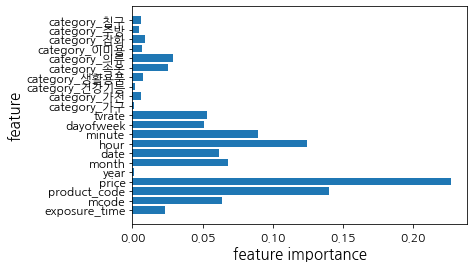

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

from sklearn import tree
clf=tree.DecisionTreeRegressor()
clf=clf.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)

import numpy as np
import matplotlib.pyplot as plt

important=clf.feature_importances_
idx=np.arange(len(dfcolumns))
plt.barh(idx,important,align='center')
plt.yticks(idx,dfcolumns)
plt.xlabel('feature importance',size=15)
plt.ylabel('feature',size=15)
plt.show()

In [18]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(y_test,y_pred)


597.9074121344371

# lightgbm

556.6241740720171


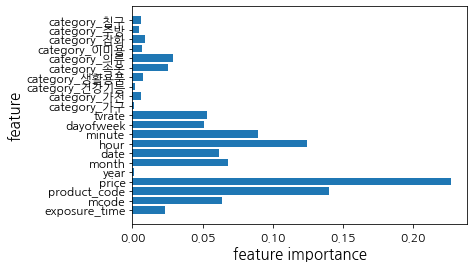

In [19]:
nonascii=dfcolumns
nonascii_dic={}
for i in range(len(nonascii)):
    nonascii_dic[dfcolumns[i]]=i
nonascii_dic
X.columns=X.columns.map(nonascii_dic)
y.columns=[0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=100)

import lightgbm as lgb
model = lgb.LGBMRegressor(random_state=0, n_estimators=1000)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
model_score = mape(y_test,predicted)
print(model_score)

import numpy as np
import matplotlib.pyplot as plt

important=clf.feature_importances_
idx=np.arange(len(dfcolumns))
plt.barh(idx,important,align='center')
plt.yticks(idx,dfcolumns)
plt.xlabel('feature importance',size=15)
plt.ylabel('feature',size=15)
plt.show()

# 그외
#https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163684